In [1]:
from Model import Model
import pandas as pd
import numpy as np
import itertools
import shap
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

In [2]:
model = Model('xgb')

In [3]:
X,Y = model.preprocessing.load_data('./Agg_data_from_frame_295.xlsx',labels=False,sheet_name="Sheet1")
Y_old = model.preprocessing.load_Y('../Updated_targets_300519.xlsx',video_name=False,column_name="diff")
Y_new = model.preprocessing.load_Y('../../Frame_Analysis/new_targets.xlsx',video_name=False,column_name="diff")

In [64]:
Y_new

,Interest_peak,Interest_mean_score,Purchase_intent,Persuasion_mean,Persuasion_very_likely,Interest_peak_frames
185 Brand Moments_Microsoft_US_60_Learning Tools_TV_4SEG,NaN,NaN,21.00,3.05,32,NaN
200 Win10_US_30_Toney_TV,NaN,NaN,0.00,0.00,0,NaN
201 Win10_UK_30_Toney_TV,NaN,NaN,0.00,3.15,25,NaN
202 Win10_US_30_Katie_TV,NaN,NaN,0.00,0.00,0,NaN
203 Win10_UK_30_Katie Compete_TV,NaN,NaN,0.00,3.06,23,NaN
204 Win10_AUS_30_Katie Non-Compete_TV,NaN,NaN,0.00,2.51,30,NaN
205 Win10_AUS_30_Katie Compete_TV,NaN,NaN,0.00,2.66,26,NaN
206 Win10_UK_30_Katie Non-Compete_TV,NaN,NaN,0.00,2.91,29,NaN
207 Win10_US_15_Toney Inking_TV,NaN,NaN,0.00,3.09,40,NaN
208 Win10_US_15_Toney Drawing_TV,NaN,NaN,0.00,3.00,26,NaN


In [4]:
X = X.set_index(X['Video Name'])
# X = X.drop('Unnamed: 0',1)
Y_old['Video Name'] = Y_old.index.values
Y_new['Video Name'] = Y_new.index.values

Y_new = Y_new[Y_new['Video Name']!= 'Surface Laptop_UK_30_Courtney v2 US VO_TV']
Y_new = Y_new[Y_new['Video Name']!='284 Surface Laptop_UK_30_Courtney v2 US VO_TV' ]
Y_new = Y_new.drop('Video Name',1)
Y = pd.concat((Y_old,Y_new),axis=1)
X = X.loc[X['Campaign']=='Surface']
Y = Y.loc[X.index.values,:]

In [5]:
Y.dropna(how='all')
X,Y= model.preprocessing.clean_data(X,Y)

In [6]:
surface_pro_frames = [col for col in X.columns if "Surface Pro".lower() in col.lower()]
for suf in ['_dur','_first_ocr','_last_ocr','_total_ocr']:
    cols = [col+suf for col in surface_pro_frames[:10]]
    X = model.preprocessing.addNewFeature(X,cols,_type="sum",new_column_name="Surface"+suf)
X = X.drop(surface_pro_frames,axis=1)

In [7]:
frame_count_columns = [col for col in X.columns.values if '_dur' in col]
columns_removed =[]
for x in X.columns.values:
    if '_frame_count' in x:
        columns_removed.append(x)
cols = [col[:-12] for col in columns_removed]
for x in frame_count_columns:
#     if x+'_dur' in X.columns.values or '_frame_count' in x:
    if x[:-4] not in cols:
        columns_removed.append(x[:-4])
columns_removed.remove('Intel')
columns_removed.remove('Surface')

In [8]:
X = X.drop(columns=columns_removed,axis=1)
columns_removed

['Female_frame_count',
 'Male_frame_count',
 'Age: 5-15_frame_count',
 'Age: 0-5_frame_count',
 'Age: 15-24_frame_count',
 'Age: 25-34_frame_count',
 'Age: 35-44_frame_count',
 'Age: 45-60_frame_count',
 'Angry_frame_count',
 'Disgust_frame_count',
 'Fear_frame_count',
 'Happiness_frame_count',
 'Neutral_frame_count',
 'Sadness_frame_count',
 'Surprise_frame_count',
 'African_frame_count',
 'Caucasian_frame_count',
 'Eastasian_frame_count',
 'Latino_frame_count',
 'microsoft',
 'ASUS T102',
 'Dell PCs',
 'Dell XPS',
 'Dell XPS 13',
 'HP Spectre x360',
 'HP Spectre x360, Windows',
 'Lenovo PCs',
 'Lenovo Yoga 720',
 'Lenovo Yoga 910',
 'MacBook Air',
 'MacBook Pro',
 'Macbook Air',
 'Microsoft Surface',
 'Suface Laptop',
 'Surface Book',
 'Surface Go',
 'Surface Laptop',
 'Surface Pen',
 'Surface laptop',
 'The surface Laptop',
 'Windows',
 'Windows 10',
 'Windows 10 PC',
 'Windows 10 PCs',
 'Windows 10, HP_Spectre',
 'Windows 10, Windows',
 'Yoga',
 'Laptop',
 'Tablet',
 'Mobile',
 'PC']

In [9]:
new_features =[["Happiness_dur",'Female_dur'],["Surprise_dur","Male_dur"],["Neutral_dur","Male_dur"],["Happiness_dur","Age: 0-5_dur"],["Disgust_dur","Age: 45-60_dur"],["Surprise_dur","Age: 0-5_dur"],["Neutral_dur","Age: 25-34_dur"],["Happiness_dur","Eastasian_dur"],["Surprise_dur","Eastasian_dur"]]
age_cols = ['Age: 5-15_dur', 'Age: 0-5_dur', 'Age: 15-24_dur','Age: 25-34_dur', 'Age: 35-44_dur', 'Age: 45-60_dur']
ethinicity_cols = ['African_dur', 'Caucasian_dur', 'Eastasian_dur','Latino_dur']
age_ethinicity_col = list(itertools.product(age_cols,ethinicity_cols))
new_features.extend(age_ethinicity_col)
X = model.preprocessing.addNewFeature(X,new_features,_type='per')
X['Happiness_length_of_ad_impact'] = X['Happiness_dur'] * (1-X['length_of_ad_15'])

In [10]:
model.preprocessing.checkNull(X).head()
X= model.preprocessing.removeNULLColumns(X,percentage=0.8)
model.preprocessing.checkNull(X).head()

African_dur                 78.1250
Age: 35-44_Eastasian_dur    78.1250
Age: 35-44_dur              75.0000
Sadness_dur                 62.5000
Happiness_Eastasian_dur     57.8125
dtype: float64

In [11]:
ocr_columns = [col for col in X.columns if "ocr" in col]

X[ocr_columns] = model.preprocessing.imputeConstant(X,columns=ocr_columns,constant=-1)
X = model.preprocessing.replace(X,np.inf,np.nan)

In [12]:
X = model.preprocessing.imputeConstant(X,constant=0)
X = X.fillna(0)

In [13]:
# Y = model.preprocessing.imputeMedian(Y,model.preprocessing.targets)
Y.isna().sum()

Unaided_Branding                    38
Brand_Cues__Mean                     0
Aided_Branding__Mean                 0
Active_Involvement__Mean             0
New_Information__Mean                0
Enjoyment__Mean                      0
Brand_Appeal__Mean                   0
Understanding__Mean                  0
Relevance_of_Information__Mean       0
Credibility_of_Information__Mean     0
Brand_Difference__Mean               0
Video Name                           0
Interest_peak                       37
Interest_mean_score                 37
Purchase_intent                      0
Persuasion_mean                      0
Persuasion_very_likely               0
Interest_peak_frames                37
dtype: int64

In [14]:
len(X.columns.values)

64

In [15]:
Y_14 = Y.loc[:,Y.isna().sum()==0]
Y_4 = Y.loc[:,Y.isna().sum()!=0]
X_4 = X[Y_4['Unaided_Branding'].isna()==False]
Y_4 = Y_4[Y_4['Unaided_Branding'].isna()==False]

In [16]:
X_res_14,Y_res_14 = model.preprocessing.overSampling(X,Y_14.drop('Video Name',1),each_Col=False,size=1000,random_state=12)
X_train_14,X_test_14,y_train_14,y_test_14 = train_test_split(X_res_14,Y_res_14,random_state = 123,test_size=0.3)

X_res_4,Y_res_4 = model.preprocessing.overSampling(X_4,Y_4,each_Col=False,size=1000,random_state=12)
X_train_4,X_test_4,y_train_4,y_test_4 = train_test_split(X_res_4,Y_res_4,random_state = 123,test_size=0.3)

In [17]:
print("------------------------ 14 Models Training ----------------------------\n")
models_14 = model.train(X_train_14,y_train_14,X_test_14,y_test_14,metrics='r2',plot_error=False)
print("------------------------ 4 Models Training ----------------------------\n")
models_4 = model.train(X_train_4,y_train_4,X_test_4,y_test_4,metrics='r2',plot_error=False)

------------------------ 14 Models Training ----------------------------

Brand_Cues__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


For training set
r2_score: 0.868492
For test set
r2_score: 0.934869


Aided_Branding__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


For training set
r2_score: 0.870558
For test set
r2_score: 0.928851


Active_Involvement__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


For training set
r2_score: 0.956599
For test set
r2_score: 0.960631


New_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


For training set
r2_score: 0.934894
For test set
r2_score: 0.934555


Enjoyment__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


For training set
r2_score: 0.934791
For test set
r2_score: 0.952303


Brand_Appeal__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.0s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


For training set
r2_score: 0.950973
For test set
r2_score: 0.962153


Understanding__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


For training set
r2_score: 0.904552
For test set
r2_score: 0.935292


Relevance_of_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


For training set
r2_score: 0.943675
For test set
r2_score: 0.965495


Credibility_of_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


For training set
r2_score: 0.940639
For test set
r2_score: 0.963262


Brand_Difference__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


For training set
r2_score: 0.922223
For test set
r2_score: 0.954938


Purchase_intent


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.3s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


For training set
r2_score: 0.955737
For test set
r2_score: 0.956936


Persuasion_mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


For training set
r2_score: 0.952284
For test set
r2_score: 0.927385


Persuasion_very_likely


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


For training set
r2_score: 0.953763
For test set
r2_score: 0.946578


------------------------ 4 Models Training ----------------------------

Unaided_Branding


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.0s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished


For training set
r2_score: 0.980910
For test set
r2_score: 0.983407


Interest_peak


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


For training set
r2_score: 0.950322
For test set
r2_score: 0.942360


Interest_mean_score


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


For training set
r2_score: 0.979830
For test set
r2_score: 0.980029


Interest_peak_frames


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.4s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


For training set
r2_score: 0.965944
For test set
r2_score: 0.955095




Brand_Cues__Mean
Surface_total_ocr
Surface Pen_dur
Surface Go_dur
Microsoft Surface_dur
MacBook Air_dur
microsoft_first_ocr
Surface_first_ocr
Surface_last_ocr
Surface Book_dur
Tablet_last_ocr
African_dur
Tablet_total_ocr
Age: 25-34_Eastasian_dur
Tablet_first_ocr
Neutral_dur
microsoft_total_ocr
Surface laptop_dur
Laptop_dur
Happiness_length_of_ad_impact
Caucasian_dur
Age: 35-44_Eastasian_dur
Neutral_Age: 25-34_dur
Surface_dur
Laptop_last_ocr
Surface Laptop_dur
Neutral_Male_dur
Age: 35-44_dur
Age: 25-34_Caucasian_dur
microsoft_last_ocr
microsoft_dur
Laptop_total_ocr
Tablet_dur
Happiness_Female_dur
Laptop_first_ocr
Male_dur
Sadness_dur
length_of_ad_15
Eastasian_dur
Happiness_Eastasian_dur
Age: 25-34_dur
Happiness_dur
Female_dur
The surface Laptop_dur
Suface Laptop_dur
MacBook Pro_dur
ad_type_tv
Macbook Air_dur
Dell PCs_dur
Windows 10 PCs_dur
Lenovo Yoga 720_dur
Windows 10, Windows_dur
Lenovo PCs_dur
Windows 10, HP_Spectre_dur
Yoga_dur
Windows 10 PC_dur
ASUS T102_dur
Windows 10_dur
Windows

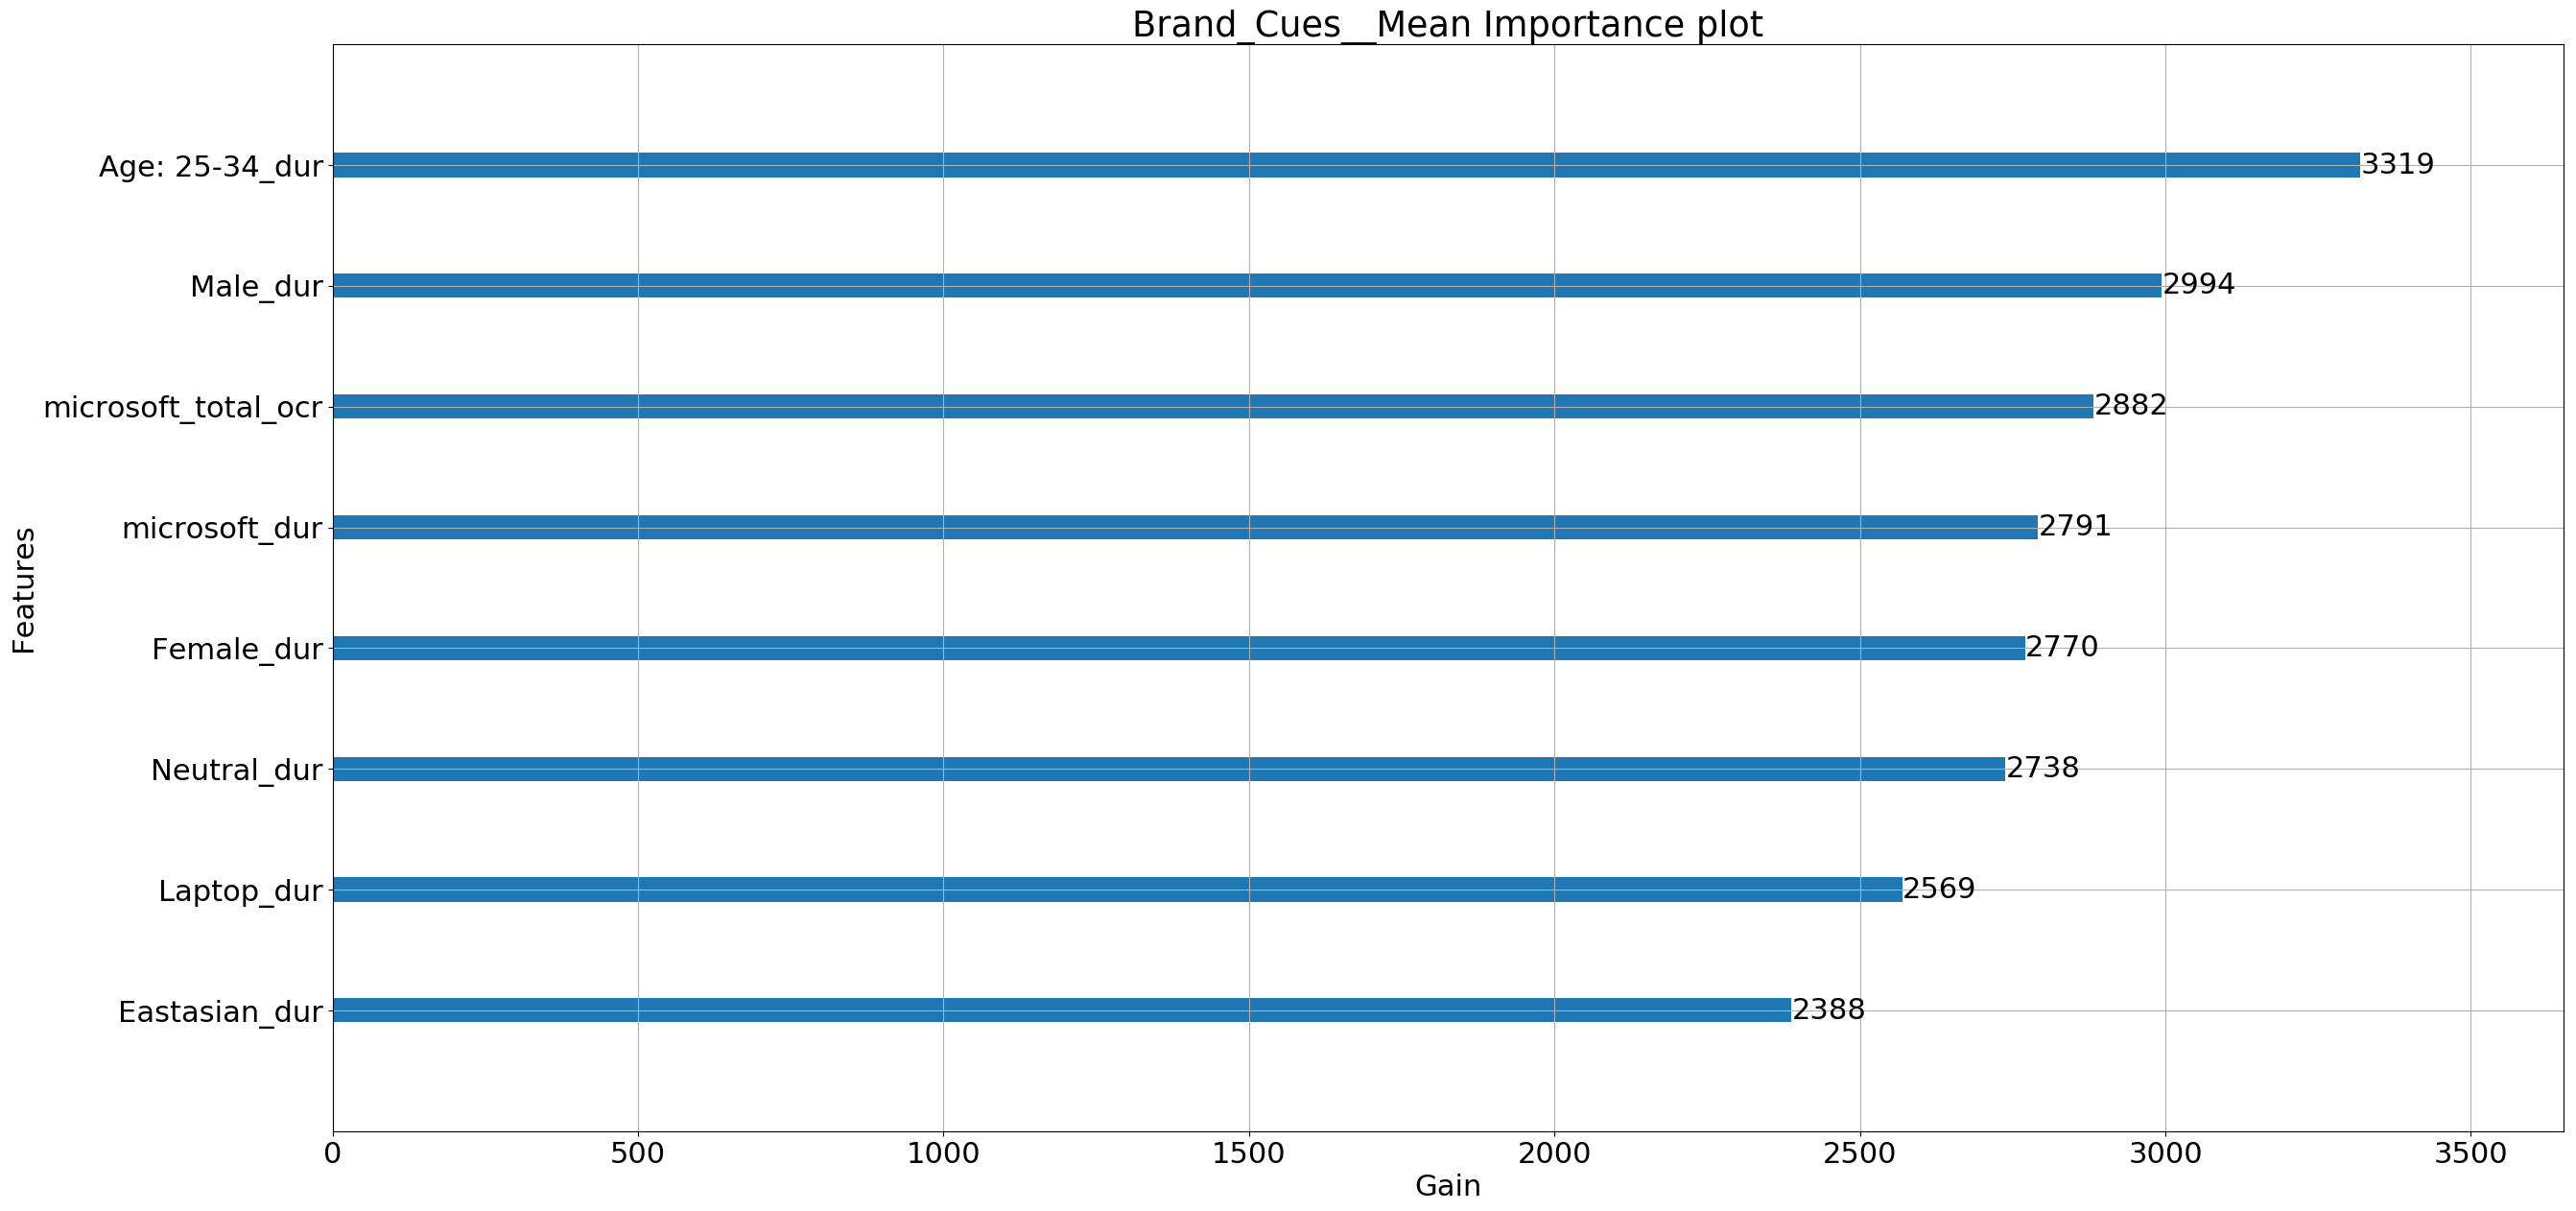

Aided_Branding__Mean
Microsoft Surface_dur
Surface Go_dur
Surface Pen_dur
Happiness_Female_dur
Tablet_last_ocr
Surface Book_dur
MacBook Air_dur
Neutral_Male_dur
Surface_first_ocr
Surface laptop_dur
African_dur
Happiness_length_of_ad_impact
microsoft_first_ocr
Surface_total_ocr
microsoft_last_ocr
Macbook Air_dur
Laptop_total_ocr
Surface_last_ocr
Tablet_total_ocr
microsoft_total_ocr
Tablet_first_ocr
Neutral_dur
Happiness_Eastasian_dur
Laptop_last_ocr
length_of_ad_15
Tablet_dur
Neutral_Age: 25-34_dur
Caucasian_dur
Sadness_dur
Surface_dur
Happiness_dur
Laptop_dur
Age: 25-34_Caucasian_dur
microsoft_dur
Eastasian_dur
Age: 25-34_dur
Female_dur
Age: 25-34_Eastasian_dur
Surface Laptop_dur
Male_dur
Laptop_first_ocr
Age: 35-44_Eastasian_dur
Age: 35-44_dur
ad_type_tv
MacBook Pro_dur
Suface Laptop_dur
The surface Laptop_dur
Yoga_dur
Windows 10_dur
Windows 10, Windows_dur
ASUS T102_dur
Dell PCs_dur
Windows_dur
Dell XPS 13_dur
HP Spectre x360_dur
HP Spectre x360, Windows_dur
Lenovo PCs_dur
Lenovo Yog

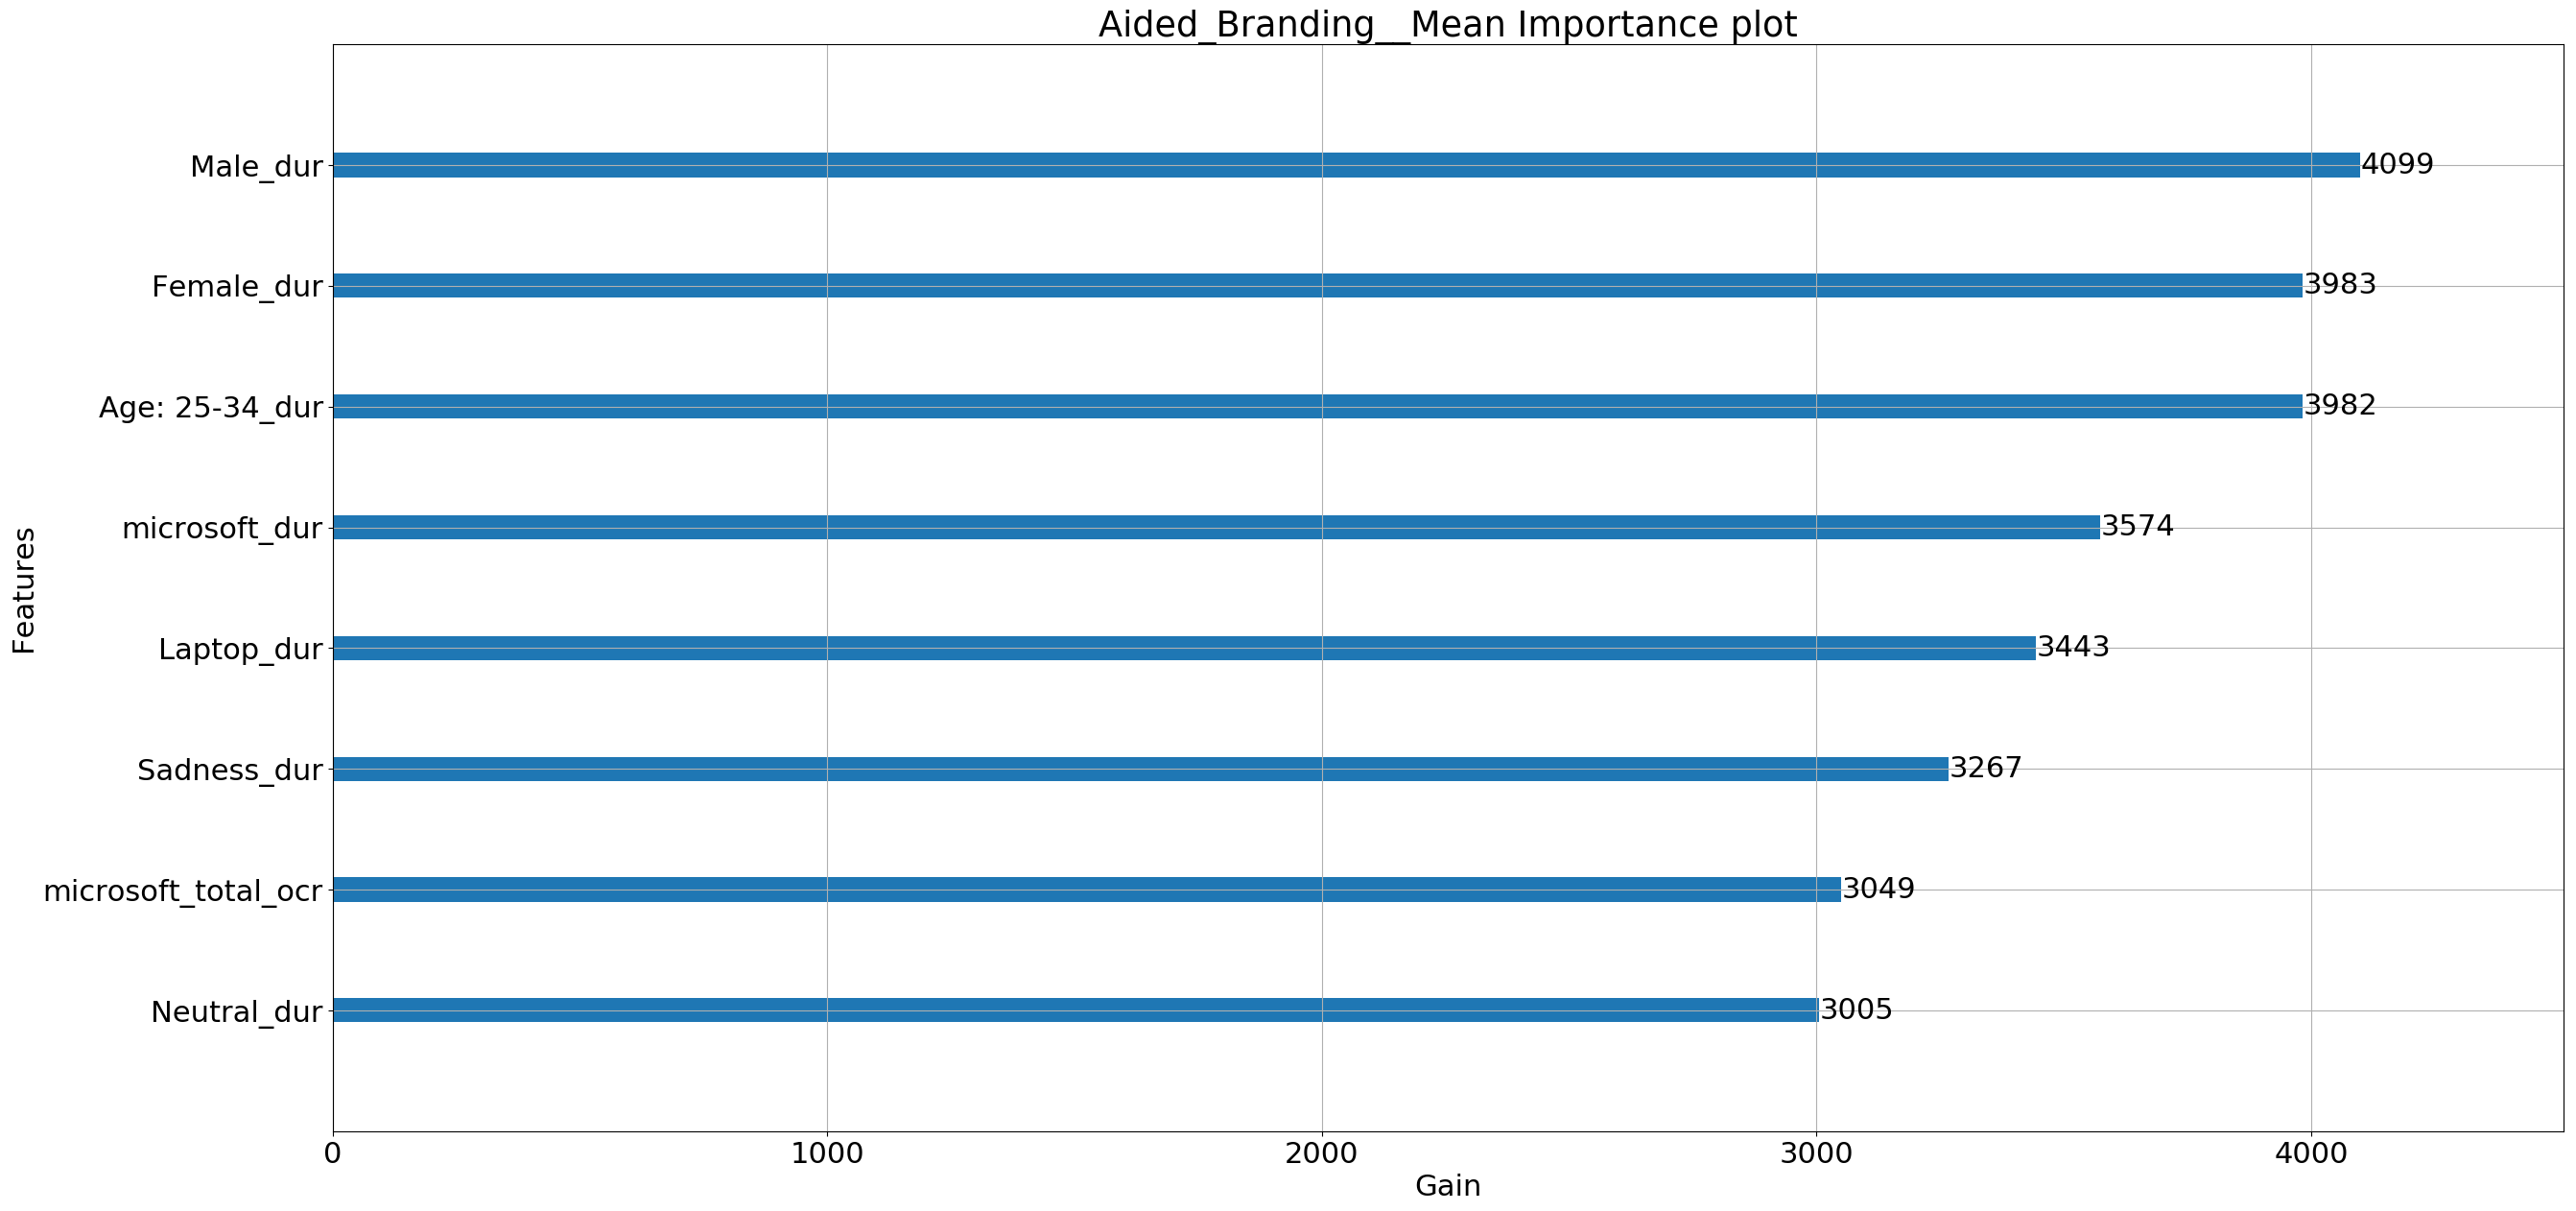

Active_Involvement__Mean
length_of_ad_15
microsoft_first_ocr
microsoft_last_ocr
Tablet_first_ocr
Laptop_dur
Laptop_last_ocr
Age: 35-44_Eastasian_dur
Age: 25-34_Eastasian_dur
Tablet_total_ocr
The surface Laptop_dur
microsoft_total_ocr
Tablet_dur
Laptop_total_ocr
Neutral_Male_dur
Surface_last_ocr
Macbook Air_dur
microsoft_dur
Happiness_Female_dur
Tablet_last_ocr
Happiness_Eastasian_dur
African_dur
Caucasian_dur
Age: 25-34_dur
Surface Laptop_dur
Neutral_dur
Surface_dur
Surface Go_dur
Neutral_Age: 25-34_dur
Eastasian_dur
MacBook Pro_dur
Happiness_length_of_ad_impact
Laptop_first_ocr
Surface laptop_dur
Male_dur
Surface_first_ocr
Happiness_dur
Sadness_dur
ad_type_tv
Surface Book_dur
Age: 25-34_Caucasian_dur
Surface_total_ocr
Female_dur
Age: 35-44_dur
Surface Pen_dur
Microsoft Surface_dur
Suface Laptop_dur
MacBook Air_dur
Windows 10, Windows_dur
Yoga_dur
Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
ASUS T102_dur
Dell XPS_dur
Dell XPS 13_dur
HP Spectre x360_dur
HP Spectre x360, Wi

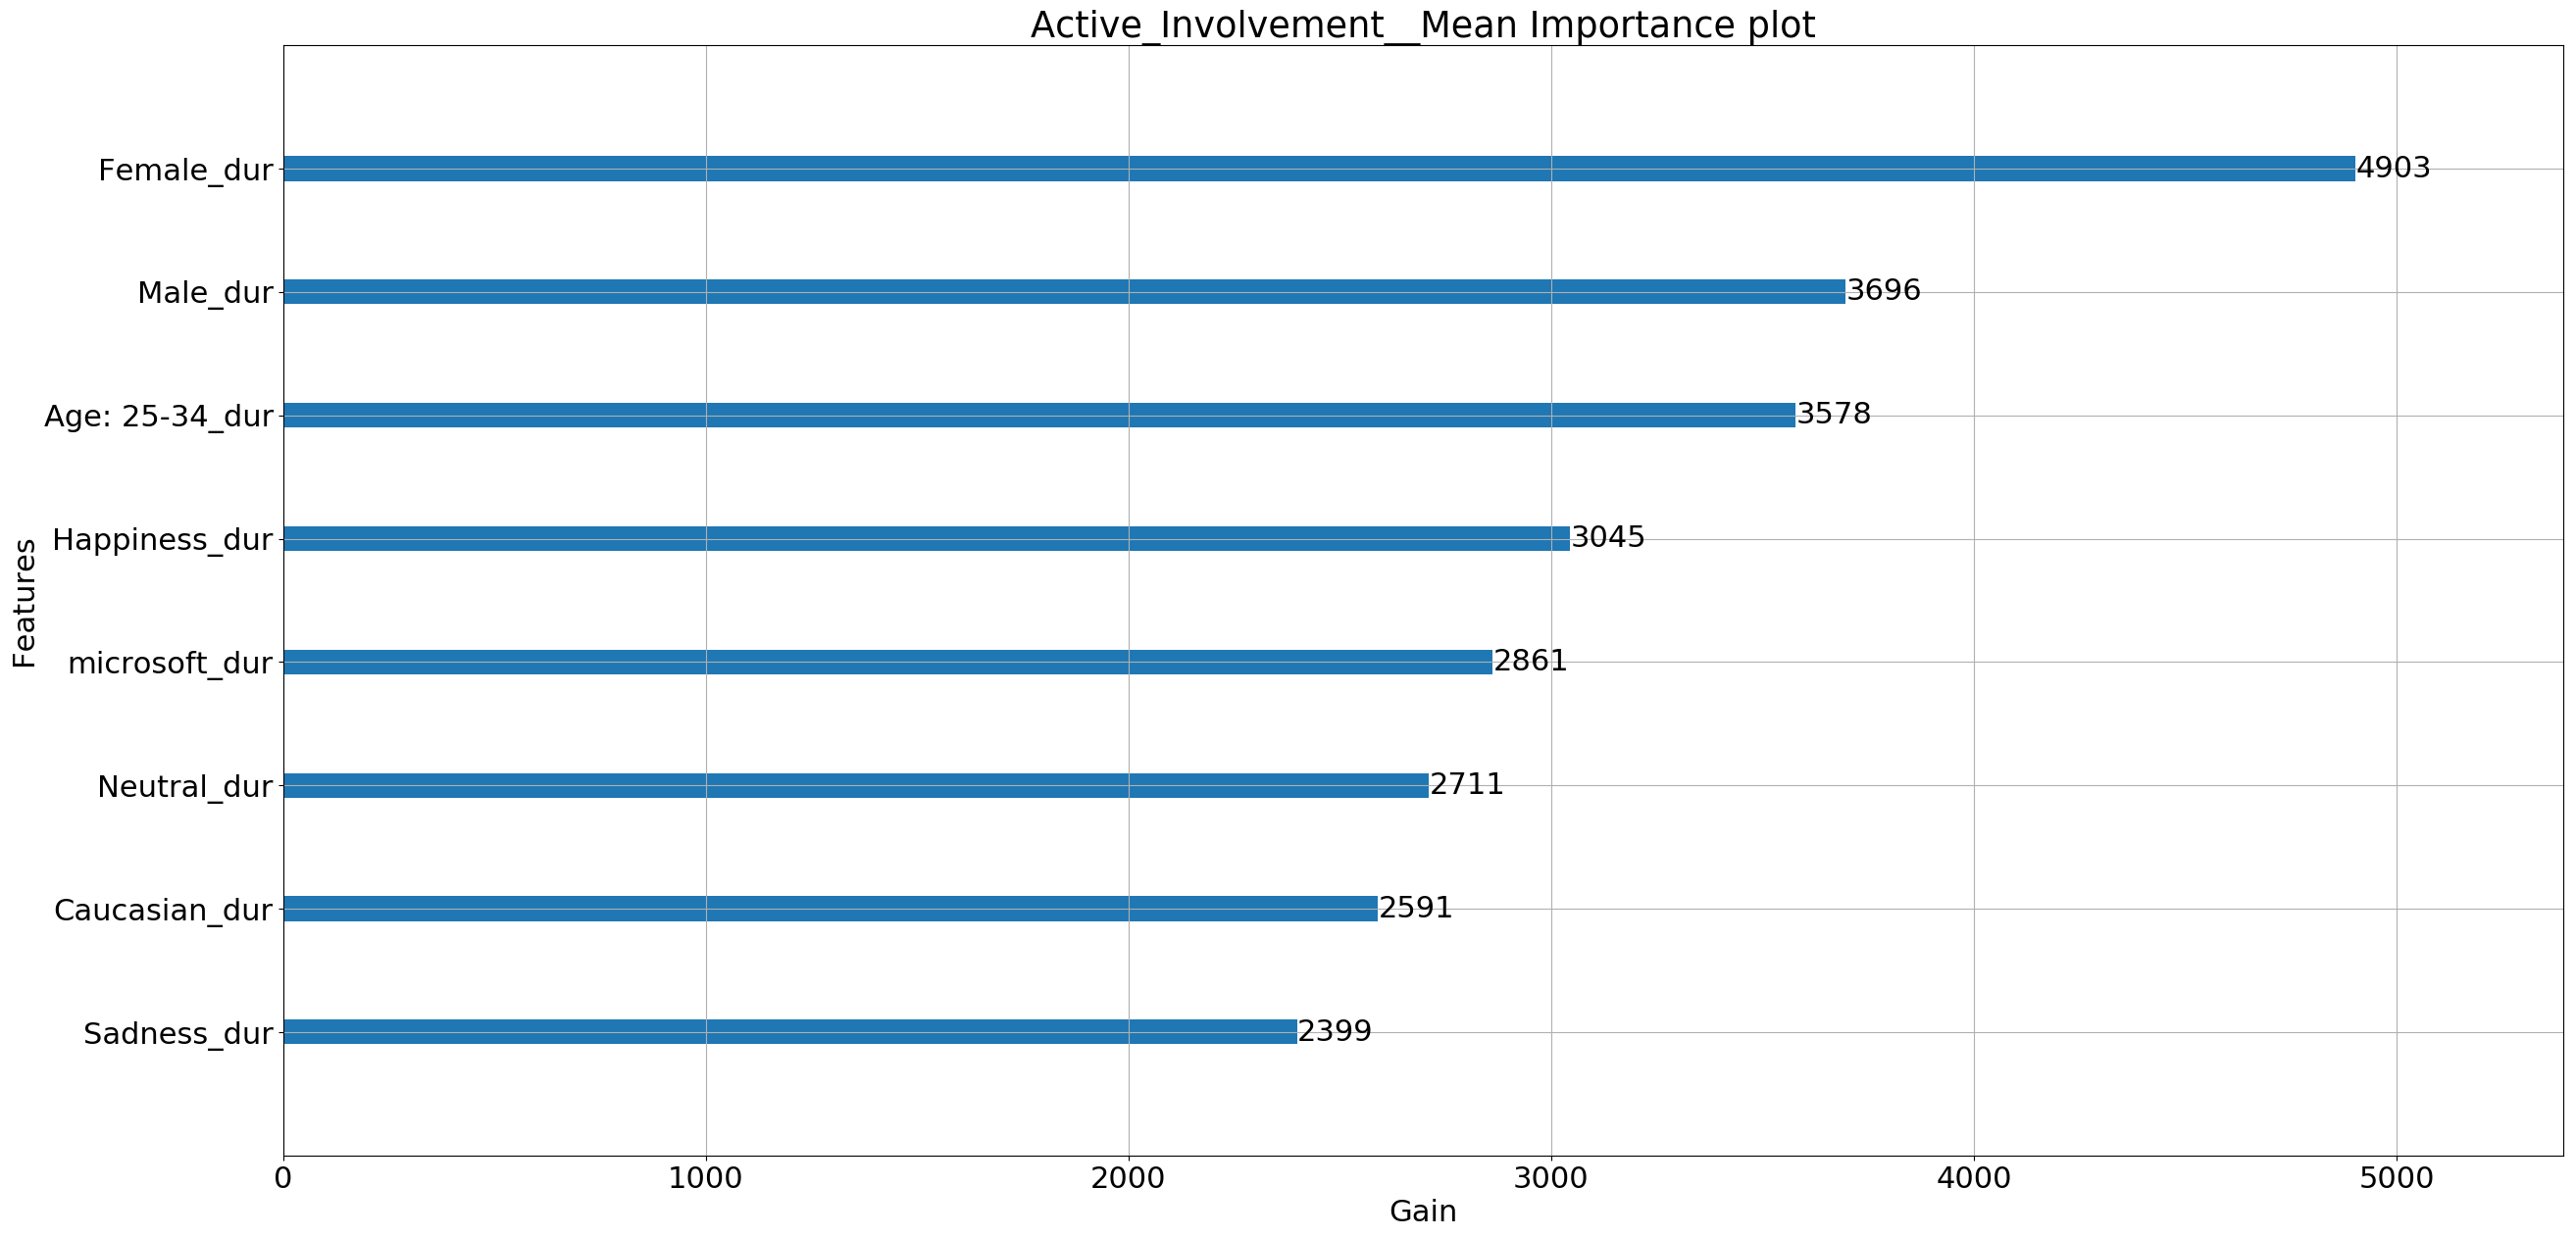

New_Information__Mean
Surface_total_ocr
length_of_ad_15
Tablet_first_ocr
Surface Go_dur
Tablet_last_ocr
Tablet_dur
Microsoft Surface_dur
MacBook Air_dur
Tablet_total_ocr
microsoft_last_ocr
Laptop_last_ocr
Neutral_Male_dur
Age: 25-34_Caucasian_dur
Surface_dur
African_dur
Happiness_Female_dur
Age: 35-44_Eastasian_dur
Laptop_total_ocr
Caucasian_dur
Age: 25-34_dur
Neutral_dur
Neutral_Age: 25-34_dur
Surface laptop_dur
Happiness_Eastasian_dur
Suface Laptop_dur
Surface Laptop_dur
Surface_last_ocr
Laptop_first_ocr
Age: 25-34_Eastasian_dur
microsoft_total_ocr
Sadness_dur
MacBook Pro_dur
Laptop_dur
Surface Book_dur
Surface_first_ocr
microsoft_first_ocr
Male_dur
Happiness_length_of_ad_impact
Age: 35-44_dur
Eastasian_dur
Happiness_dur
The surface Laptop_dur
microsoft_dur
Female_dur
ad_type_tv
Surface Pen_dur
Macbook Air_dur
Yoga_dur
Windows 10_dur
ASUS T102_dur
Dell PCs_dur
Windows_dur
Dell XPS 13_dur
HP Spectre x360_dur
HP Spectre x360, Windows_dur
Lenovo PCs_dur
Lenovo Yoga 720_dur
Lenovo Yoga 9

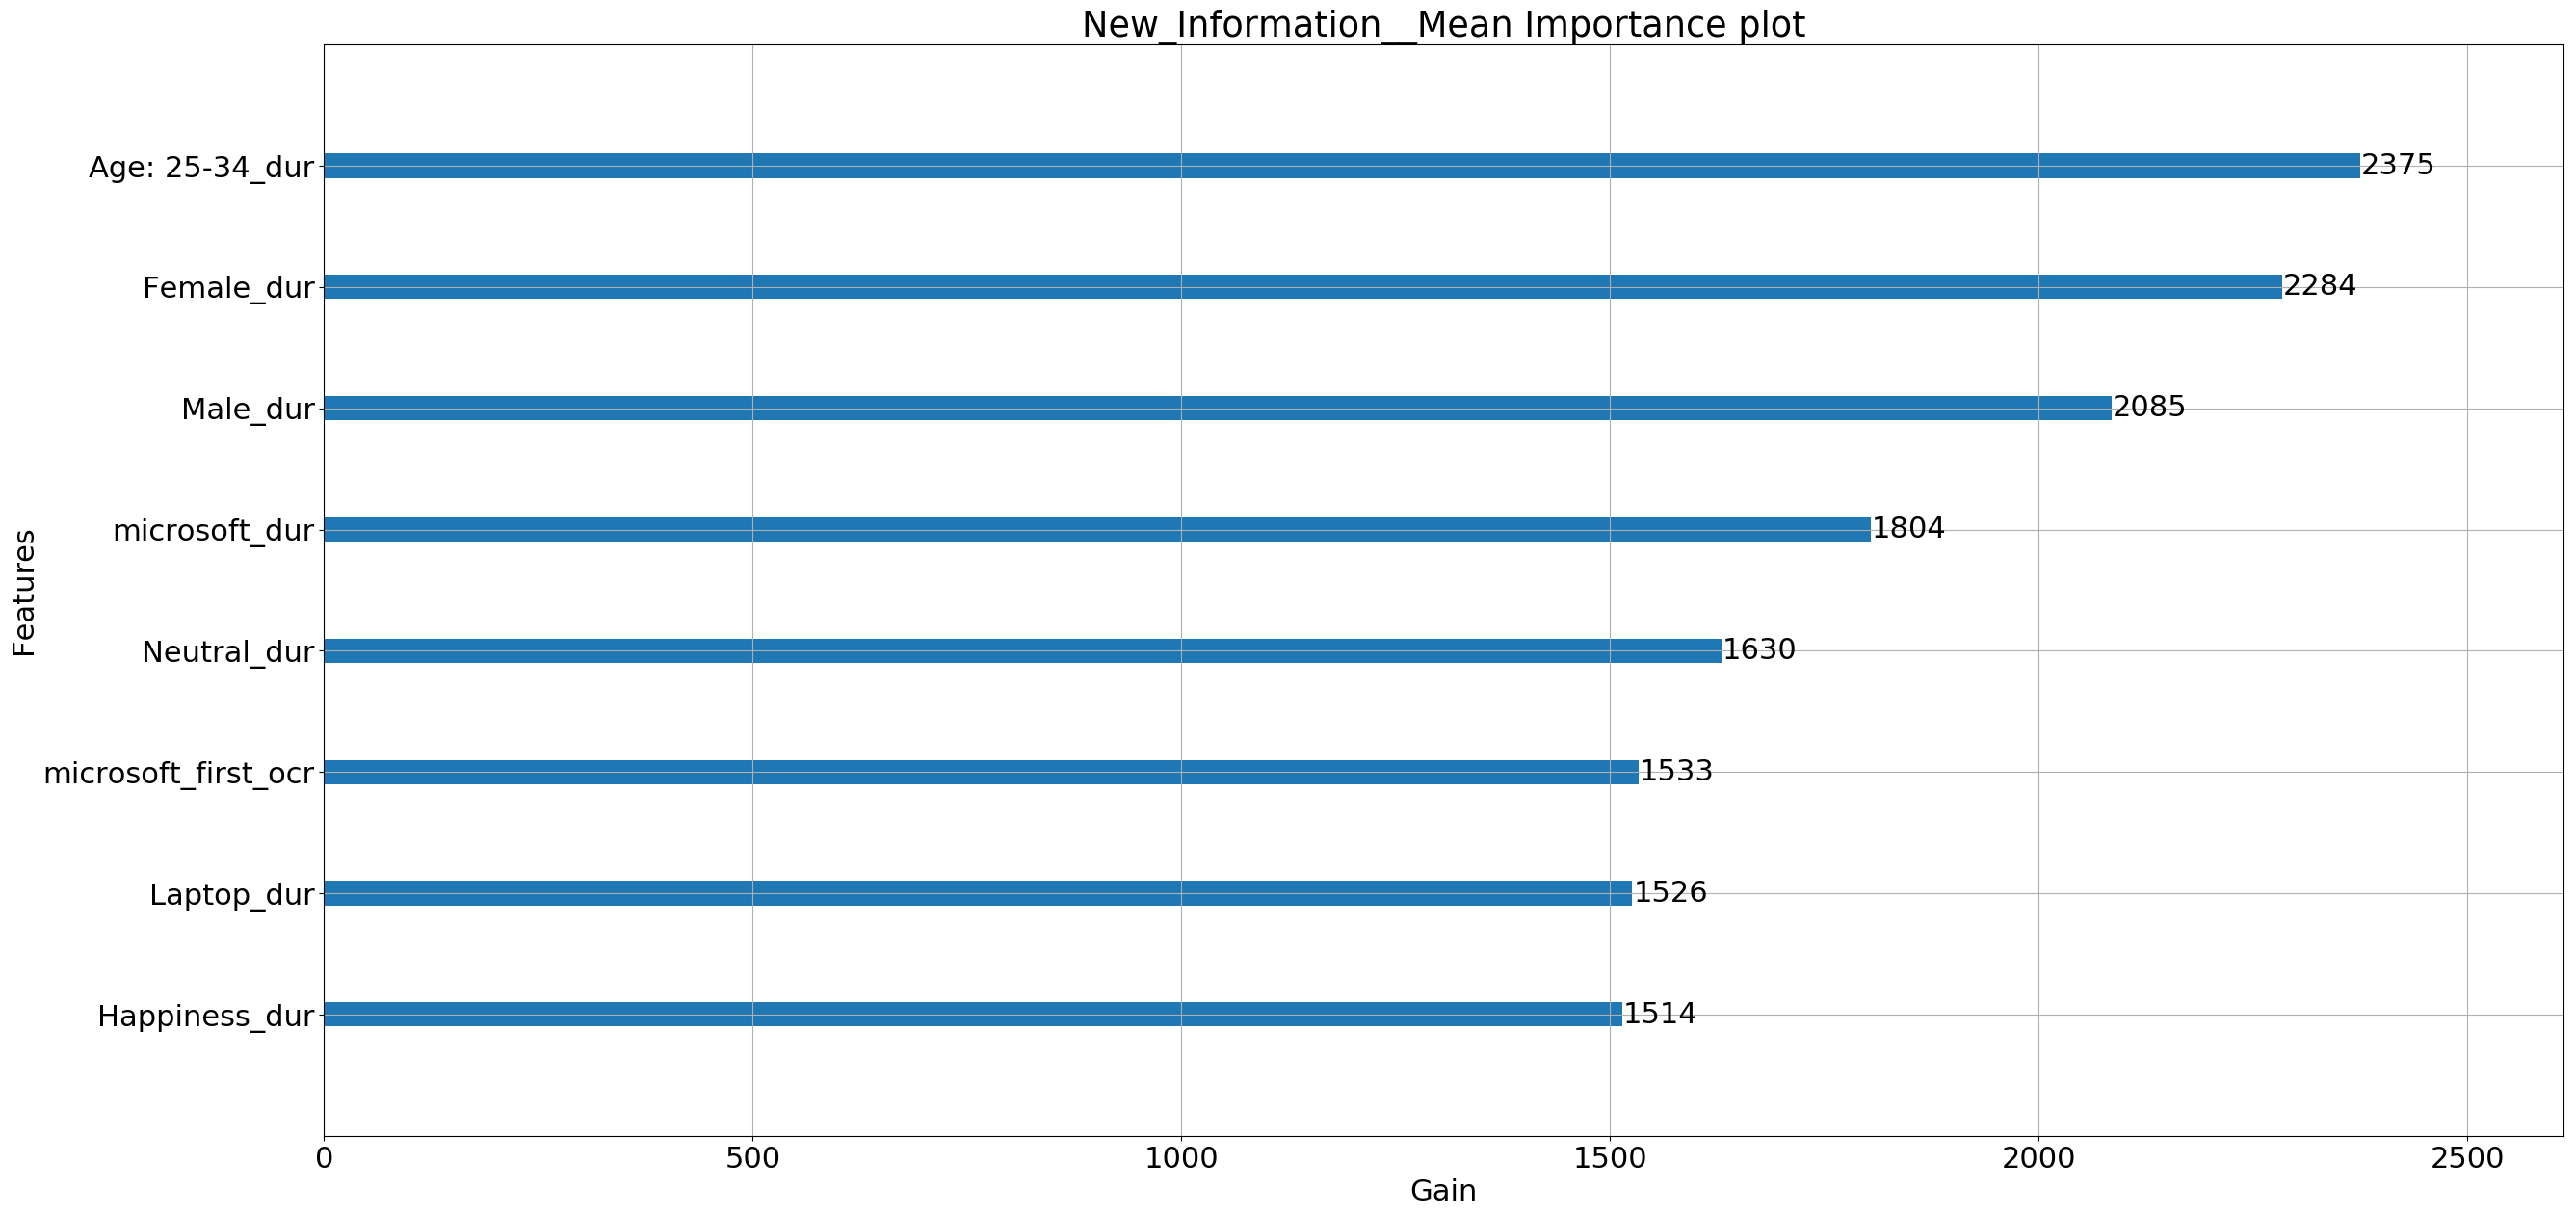

Enjoyment__Mean
length_of_ad_15
microsoft_last_ocr
Surface_total_ocr
Surface_last_ocr
Surface_dur
Caucasian_dur
Surface_first_ocr
Tablet_first_ocr
Neutral_dur
Surface Book_dur
Age: 35-44_Eastasian_dur
Laptop_total_ocr
MacBook Air_dur
Neutral_Age: 25-34_dur
Happiness_Eastasian_dur
Laptop_first_ocr
microsoft_total_ocr
Laptop_last_ocr
Laptop_dur
Neutral_Male_dur
Tablet_last_ocr
microsoft_first_ocr
Microsoft Surface_dur
Eastasian_dur
Sadness_dur
Happiness_Female_dur
Macbook Air_dur
Tablet_total_ocr
African_dur
Happiness_dur
microsoft_dur
Happiness_length_of_ad_impact
Surface Go_dur
Age: 25-34_dur
Age: 25-34_Eastasian_dur
Surface Pen_dur
Surface Laptop_dur
Tablet_dur
Age: 35-44_dur
Female_dur
Age: 25-34_Caucasian_dur
Male_dur
MacBook Pro_dur
ad_type_tv
Surface laptop_dur
Suface Laptop_dur
The surface Laptop_dur
Windows 10, HP_Spectre_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10 PCs_dur
Lenovo Yoga 910_dur
Windows 10 PC_dur
Windows 10_dur
ASUS T102_dur
Dell PCs_dur
Dell XPS_dur
Dell XPS 1

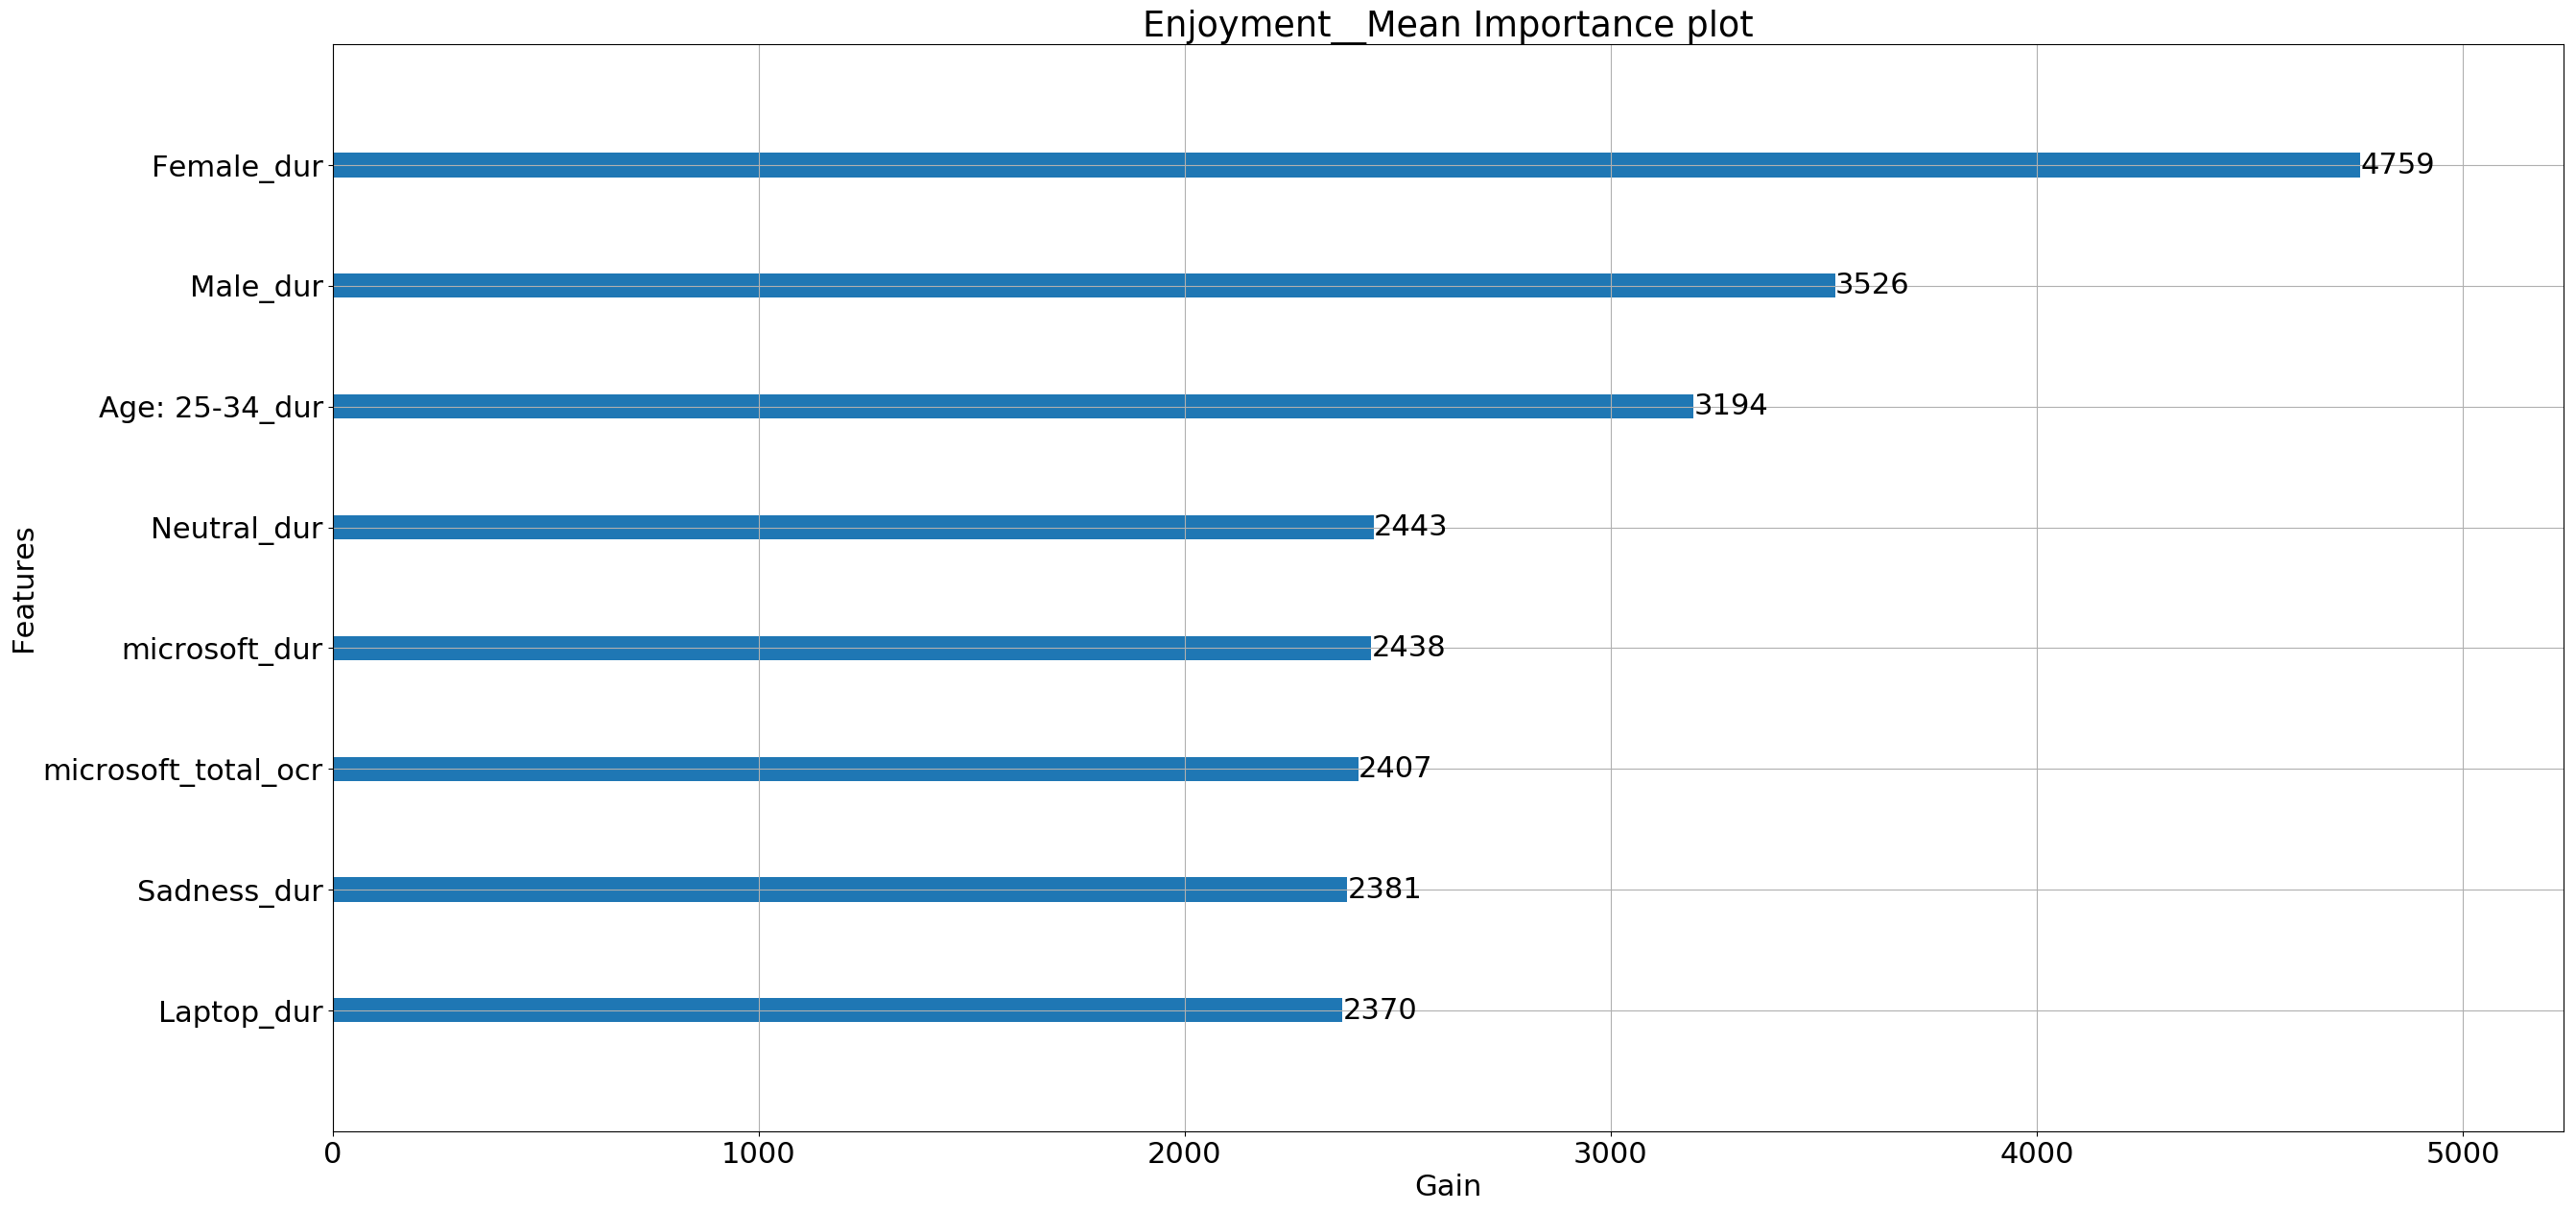

Brand_Appeal__Mean
length_of_ad_15
microsoft_last_ocr
Surface_total_ocr
The surface Laptop_dur
African_dur
MacBook Pro_dur
ad_type_tv
Surface_dur
Surface_last_ocr
Microsoft Surface_dur
Caucasian_dur
Surface laptop_dur
microsoft_first_ocr
Surface Pen_dur
Neutral_dur
Surface Book_dur
Sadness_dur
Neutral_Age: 25-34_dur
Tablet_first_ocr
MacBook Air_dur
Laptop_last_ocr
microsoft_total_ocr
Age: 35-44_Eastasian_dur
Tablet_last_ocr
Laptop_first_ocr
Happiness_Female_dur
Tablet_total_ocr
Surface_first_ocr
Neutral_Male_dur
Age: 25-34_dur
Age: 25-34_Caucasian_dur
Tablet_dur
Laptop_dur
Happiness_Eastasian_dur
Female_dur
Age: 25-34_Eastasian_dur
Laptop_total_ocr
Happiness_length_of_ad_impact
Surface Go_dur
Age: 35-44_dur
Surface Laptop_dur
microsoft_dur
Male_dur
Happiness_dur
Eastasian_dur
Suface Laptop_dur
Macbook Air_dur
HP Spectre x360_dur
Windows 10 PC_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Lenovo PCs_dur
Windows 10 PCs_dur
Windows_dur
Windows 10_dur
Dell XPS 13_dur
Leno

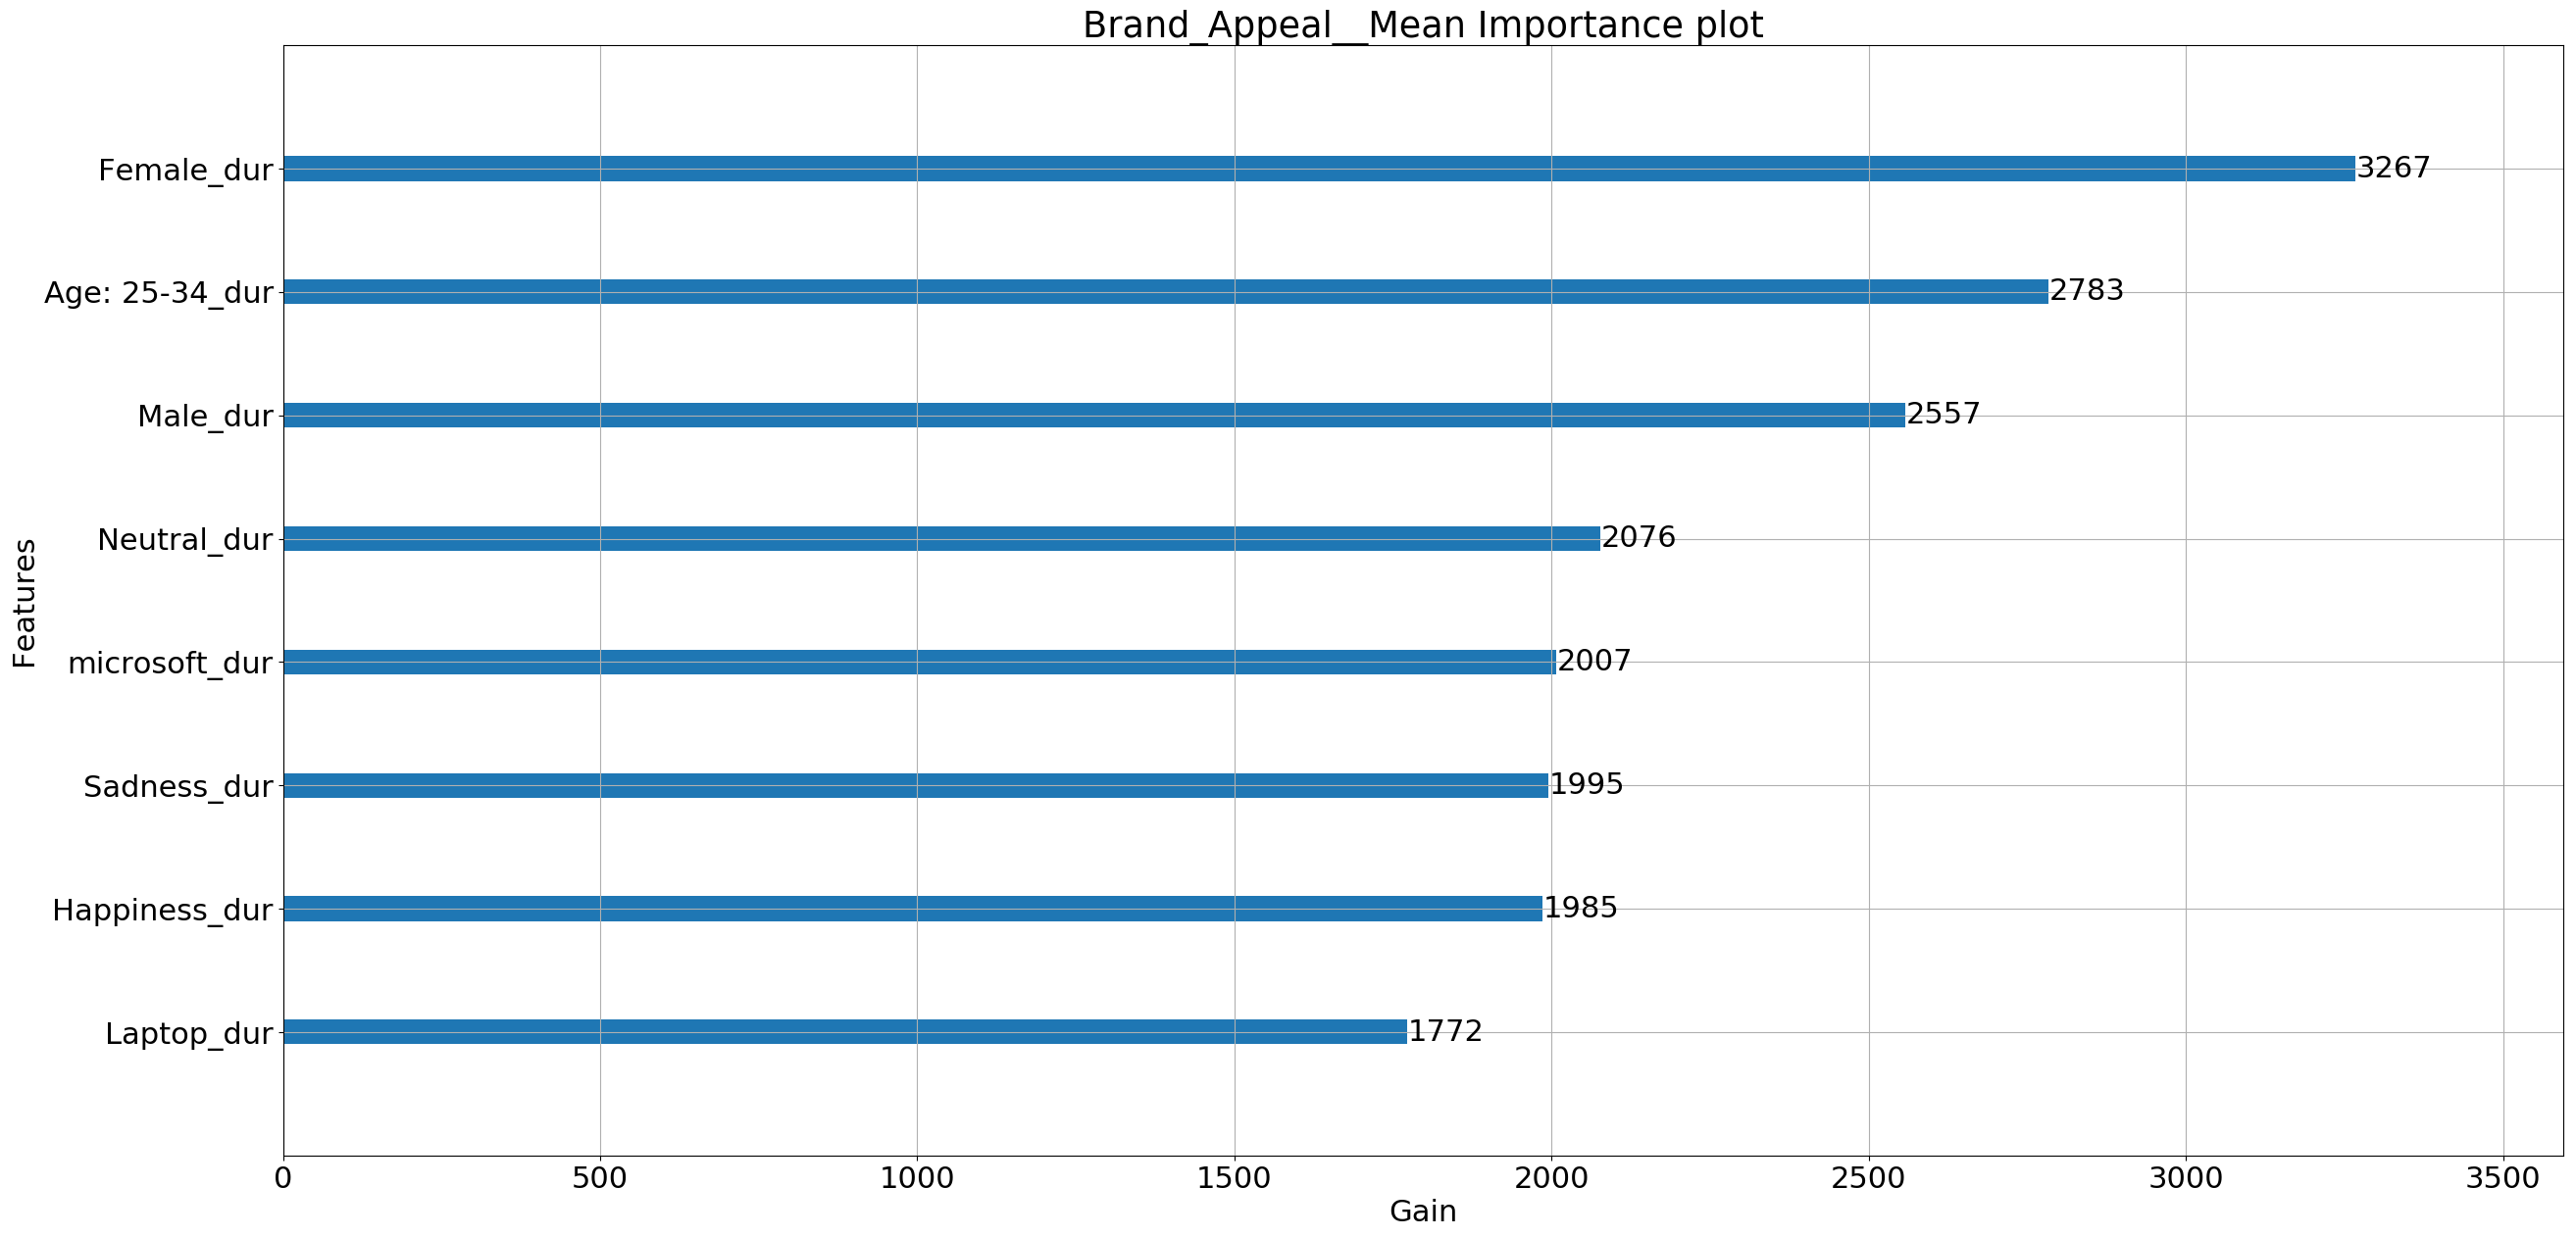

Understanding__Mean
Surface Go_dur
African_dur
Laptop_first_ocr
Surface_total_ocr
Age: 25-34_Caucasian_dur
Caucasian_dur
Tablet_first_ocr
MacBook Air_dur
Neutral_Male_dur
Tablet_total_ocr
Tablet_dur
Tablet_last_ocr
Happiness_Female_dur
Microsoft Surface_dur
Laptop_total_ocr
microsoft_first_ocr
microsoft_last_ocr
Age: 35-44_dur
Surface Book_dur
Surface_first_ocr
Age: 25-34_Eastasian_dur
Laptop_last_ocr
Laptop_dur
Age: 35-44_Eastasian_dur
Neutral_dur
Age: 25-34_dur
Sadness_dur
Surface Laptop_dur
microsoft_total_ocr
microsoft_dur
Happiness_Eastasian_dur
The surface Laptop_dur
Male_dur
Surface_dur
Neutral_Age: 25-34_dur
Happiness_length_of_ad_impact
Surface Pen_dur
Surface laptop_dur
Female_dur
Happiness_dur
Surface_last_ocr
MacBook Pro_dur
Macbook Air_dur
Eastasian_dur
length_of_ad_15
ad_type_tv
Suface Laptop_dur
Windows 10 PCs_dur
Lenovo Yoga 910_dur
Lenovo Yoga 720_dur
Yoga_dur
Windows 10, Windows_dur
Lenovo PCs_dur
Windows 10, HP_Spectre_dur
HP Spectre x360_dur
Windows 10 PC_dur
Dell X

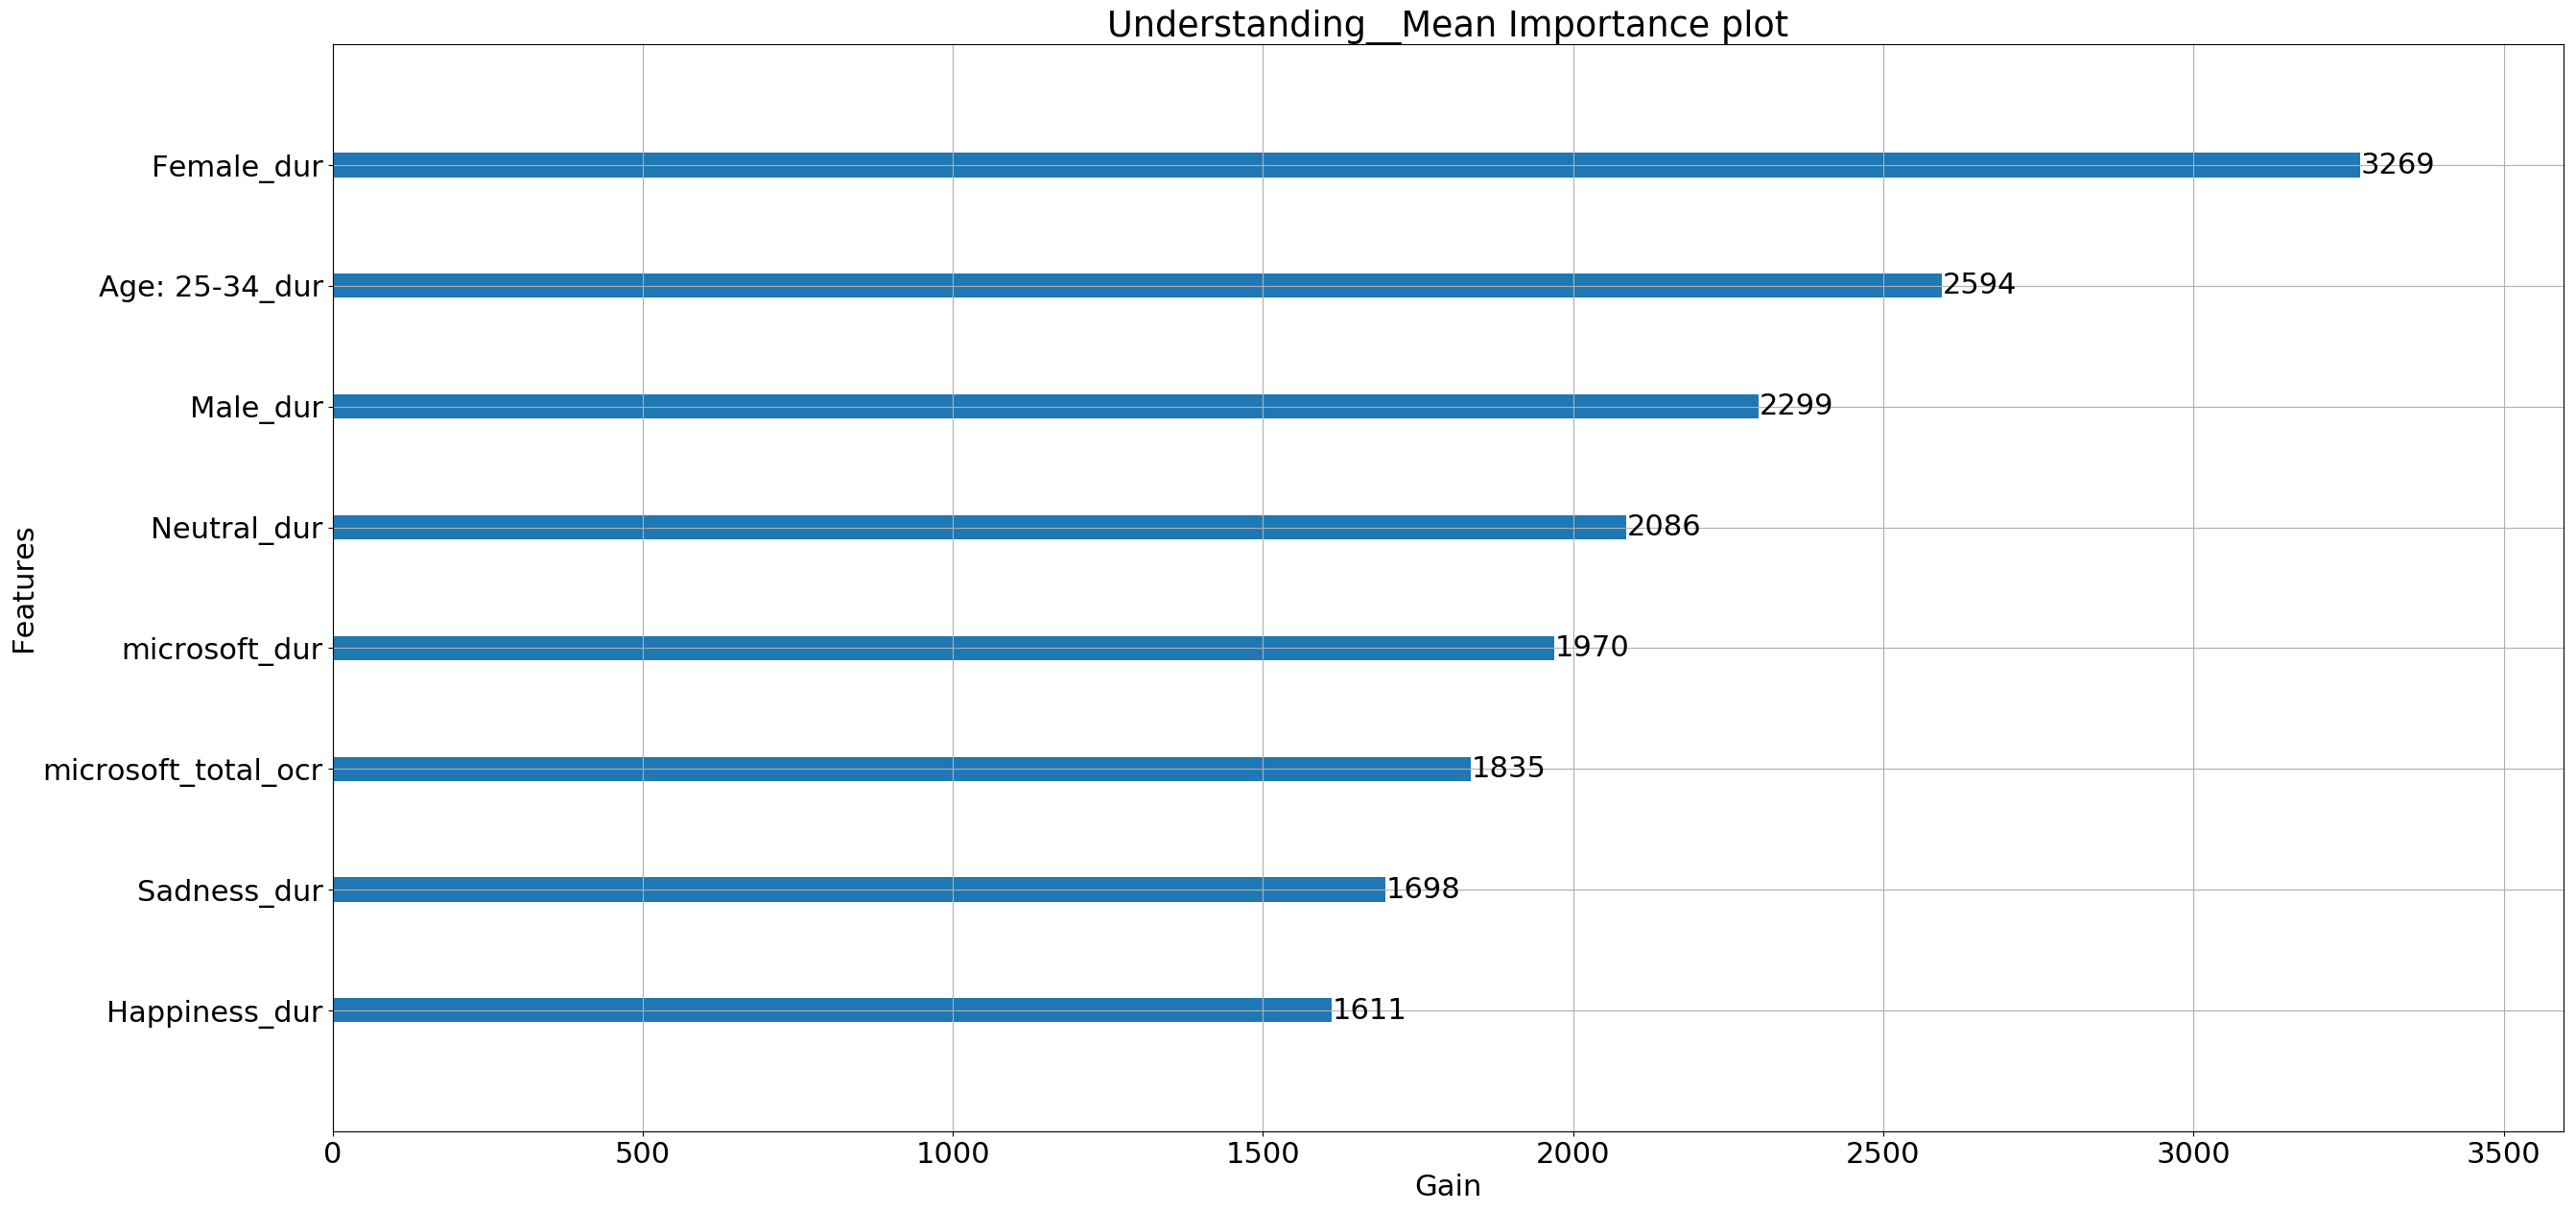

Relevance_of_Information__Mean
Surface Pen_dur
Surface Book_dur
length_of_ad_15
Surface_first_ocr
Surface_total_ocr
African_dur
Macbook Air_dur
microsoft_total_ocr
Surface_last_ocr
microsoft_last_ocr
MacBook Pro_dur
Surface_dur
Microsoft Surface_dur
Laptop_total_ocr
ad_type_tv
Happiness_length_of_ad_impact
Tablet_total_ocr
Neutral_Male_dur
Surface Go_dur
Laptop_first_ocr
Tablet_last_ocr
Tablet_first_ocr
Caucasian_dur
Age: 25-34_dur
Neutral_Age: 25-34_dur
Male_dur
Tablet_dur
Age: 25-34_Eastasian_dur
Age: 35-44_dur
Laptop_dur
Laptop_last_ocr
Happiness_dur
microsoft_first_ocr
Surface Laptop_dur
Surface laptop_dur
Happiness_Female_dur
microsoft_dur
Neutral_dur
Age: 25-34_Caucasian_dur
Happiness_Eastasian_dur
Age: 35-44_Eastasian_dur
MacBook Air_dur
Female_dur
Sadness_dur
Eastasian_dur
The surface Laptop_dur
Suface Laptop_dur
Yoga_dur
Windows 10, Windows_dur
Dell PCs_dur
ASUS T102_dur
Dell XPS_dur
Dell XPS 13_dur
HP Spectre x360_dur
HP Spectre x360, Windows_dur
Lenovo PCs_dur
Lenovo Yoga 91

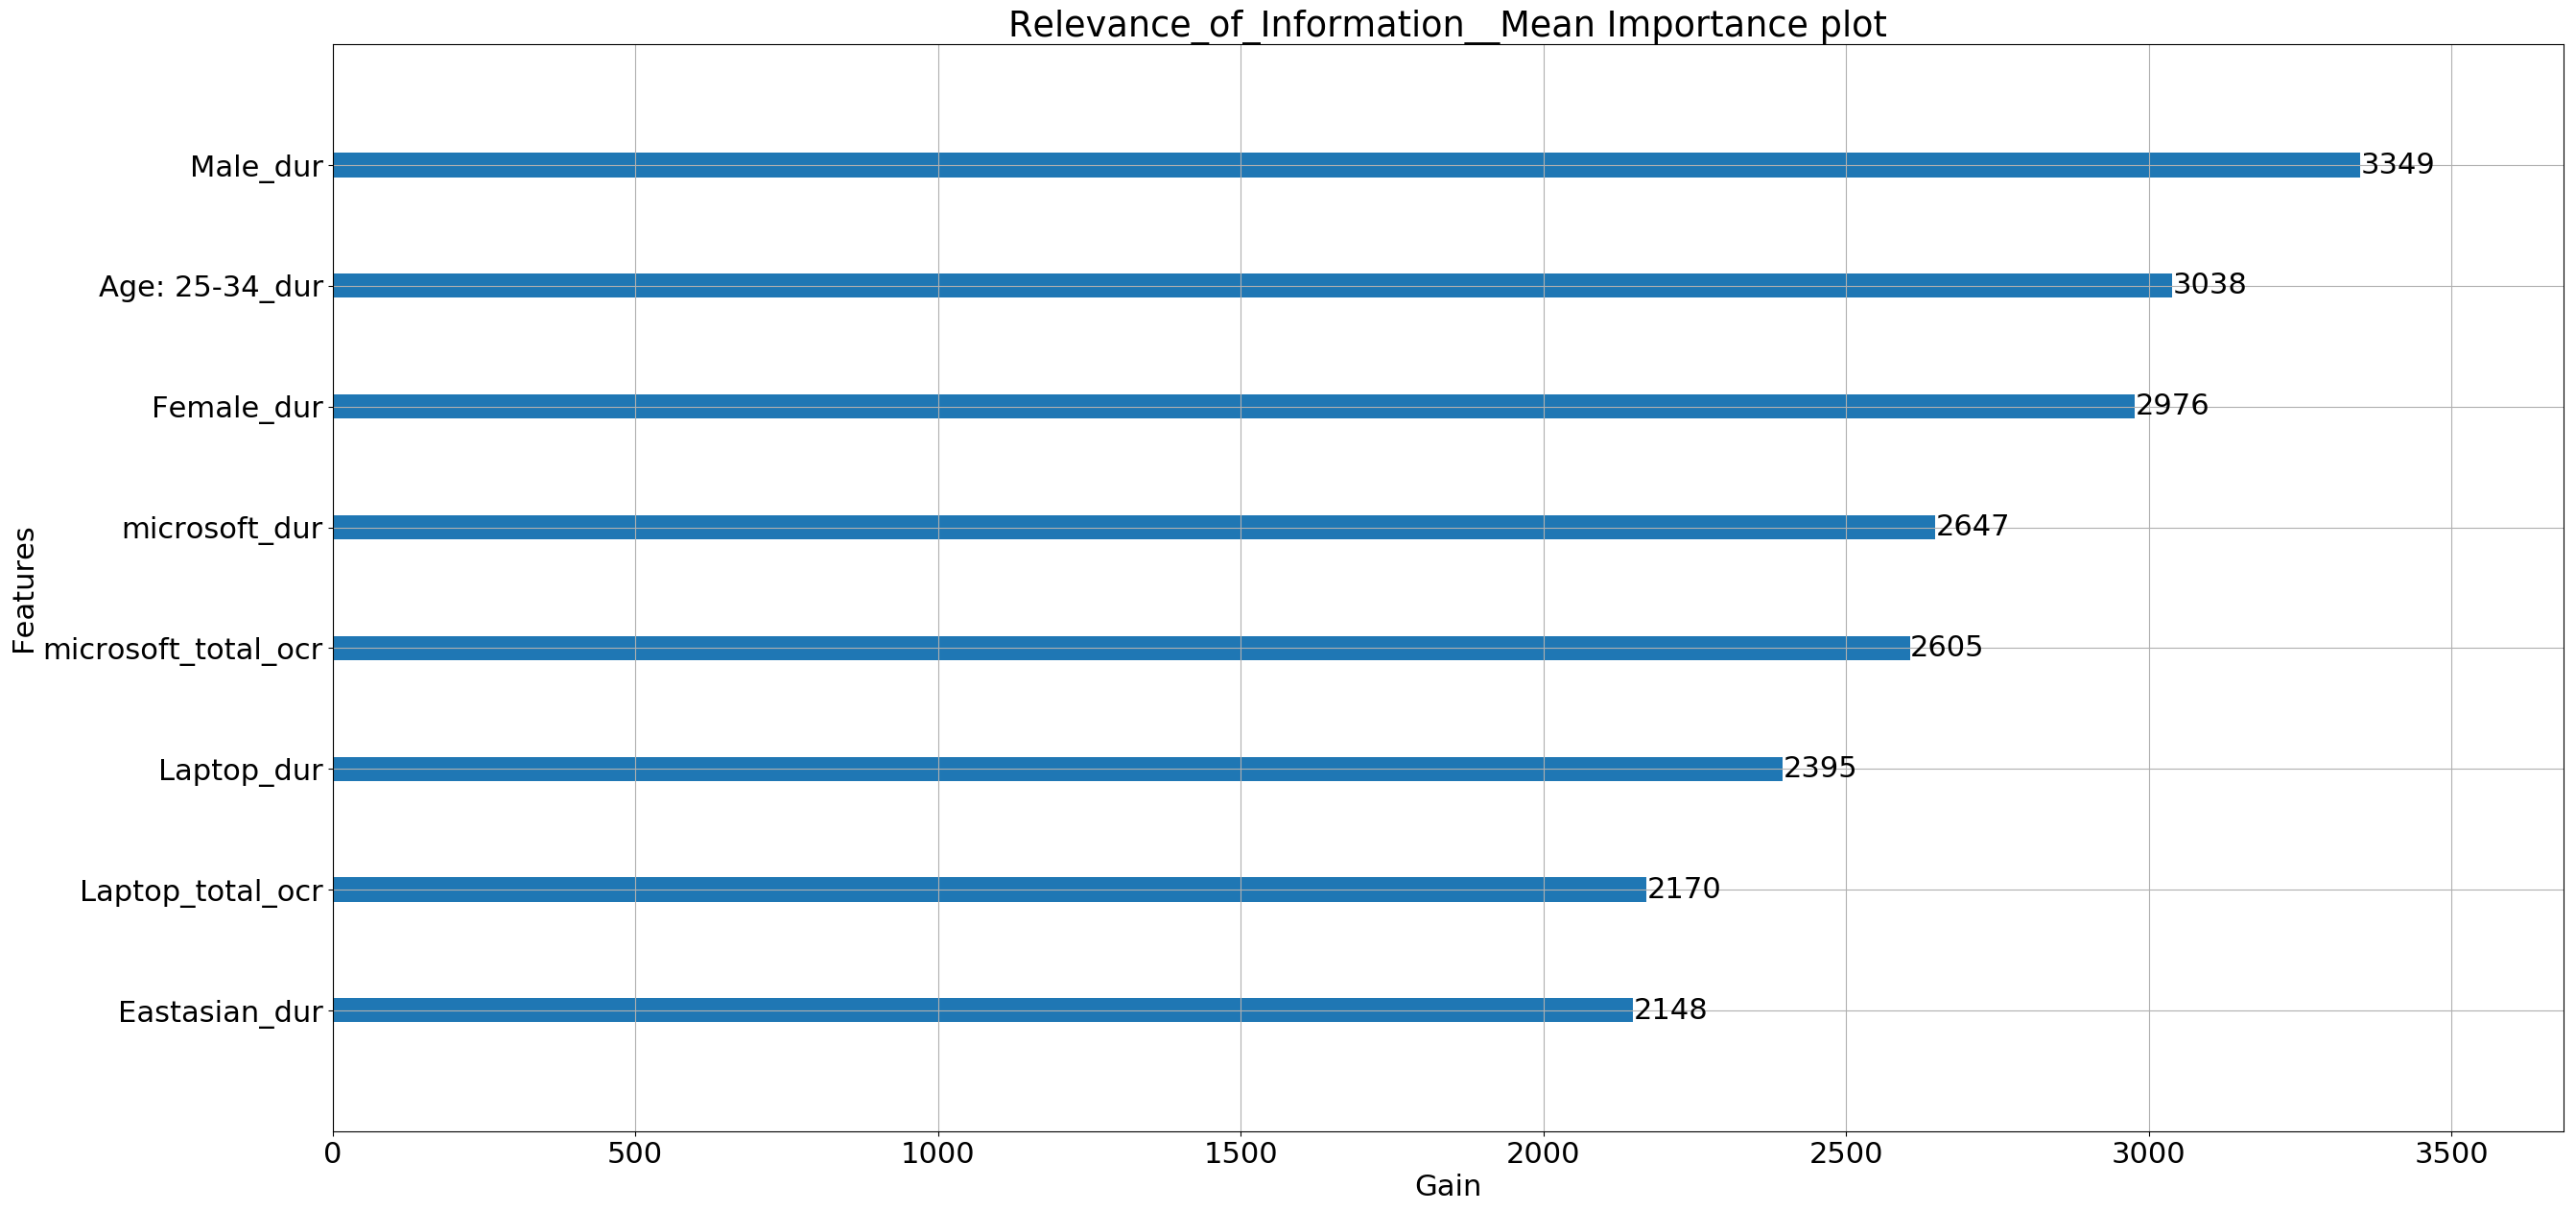

Credibility_of_Information__Mean
Surface Pen_dur
Surface Go_dur
ad_type_tv
MacBook Pro_dur
Microsoft Surface_dur
MacBook Air_dur
Surface_total_ocr
Surface_first_ocr
Surface_last_ocr
Surface_dur
Surface Book_dur
Caucasian_dur
Age: 25-34_Caucasian_dur
Male_dur
microsoft_total_ocr
Laptop_last_ocr
Macbook Air_dur
Happiness_length_of_ad_impact
Tablet_total_ocr
Laptop_first_ocr
Tablet_last_ocr
Neutral_Male_dur
Neutral_Age: 25-34_dur
Age: 25-34_Eastasian_dur
microsoft_first_ocr
Tablet_first_ocr
Laptop_total_ocr
microsoft_last_ocr
Laptop_dur
Tablet_dur
Happiness_Female_dur
African_dur
Neutral_dur
Age: 35-44_Eastasian_dur
Age: 25-34_dur
length_of_ad_15
Surface laptop_dur
Happiness_dur
Surface Laptop_dur
Happiness_Eastasian_dur
microsoft_dur
Sadness_dur
Eastasian_dur
Age: 35-44_dur
The surface Laptop_dur
Female_dur
Suface Laptop_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
Windows 10_dur
Windows_dur
ASUS T102_dur
Dell PCs_dur
Dell XPS_dur
D

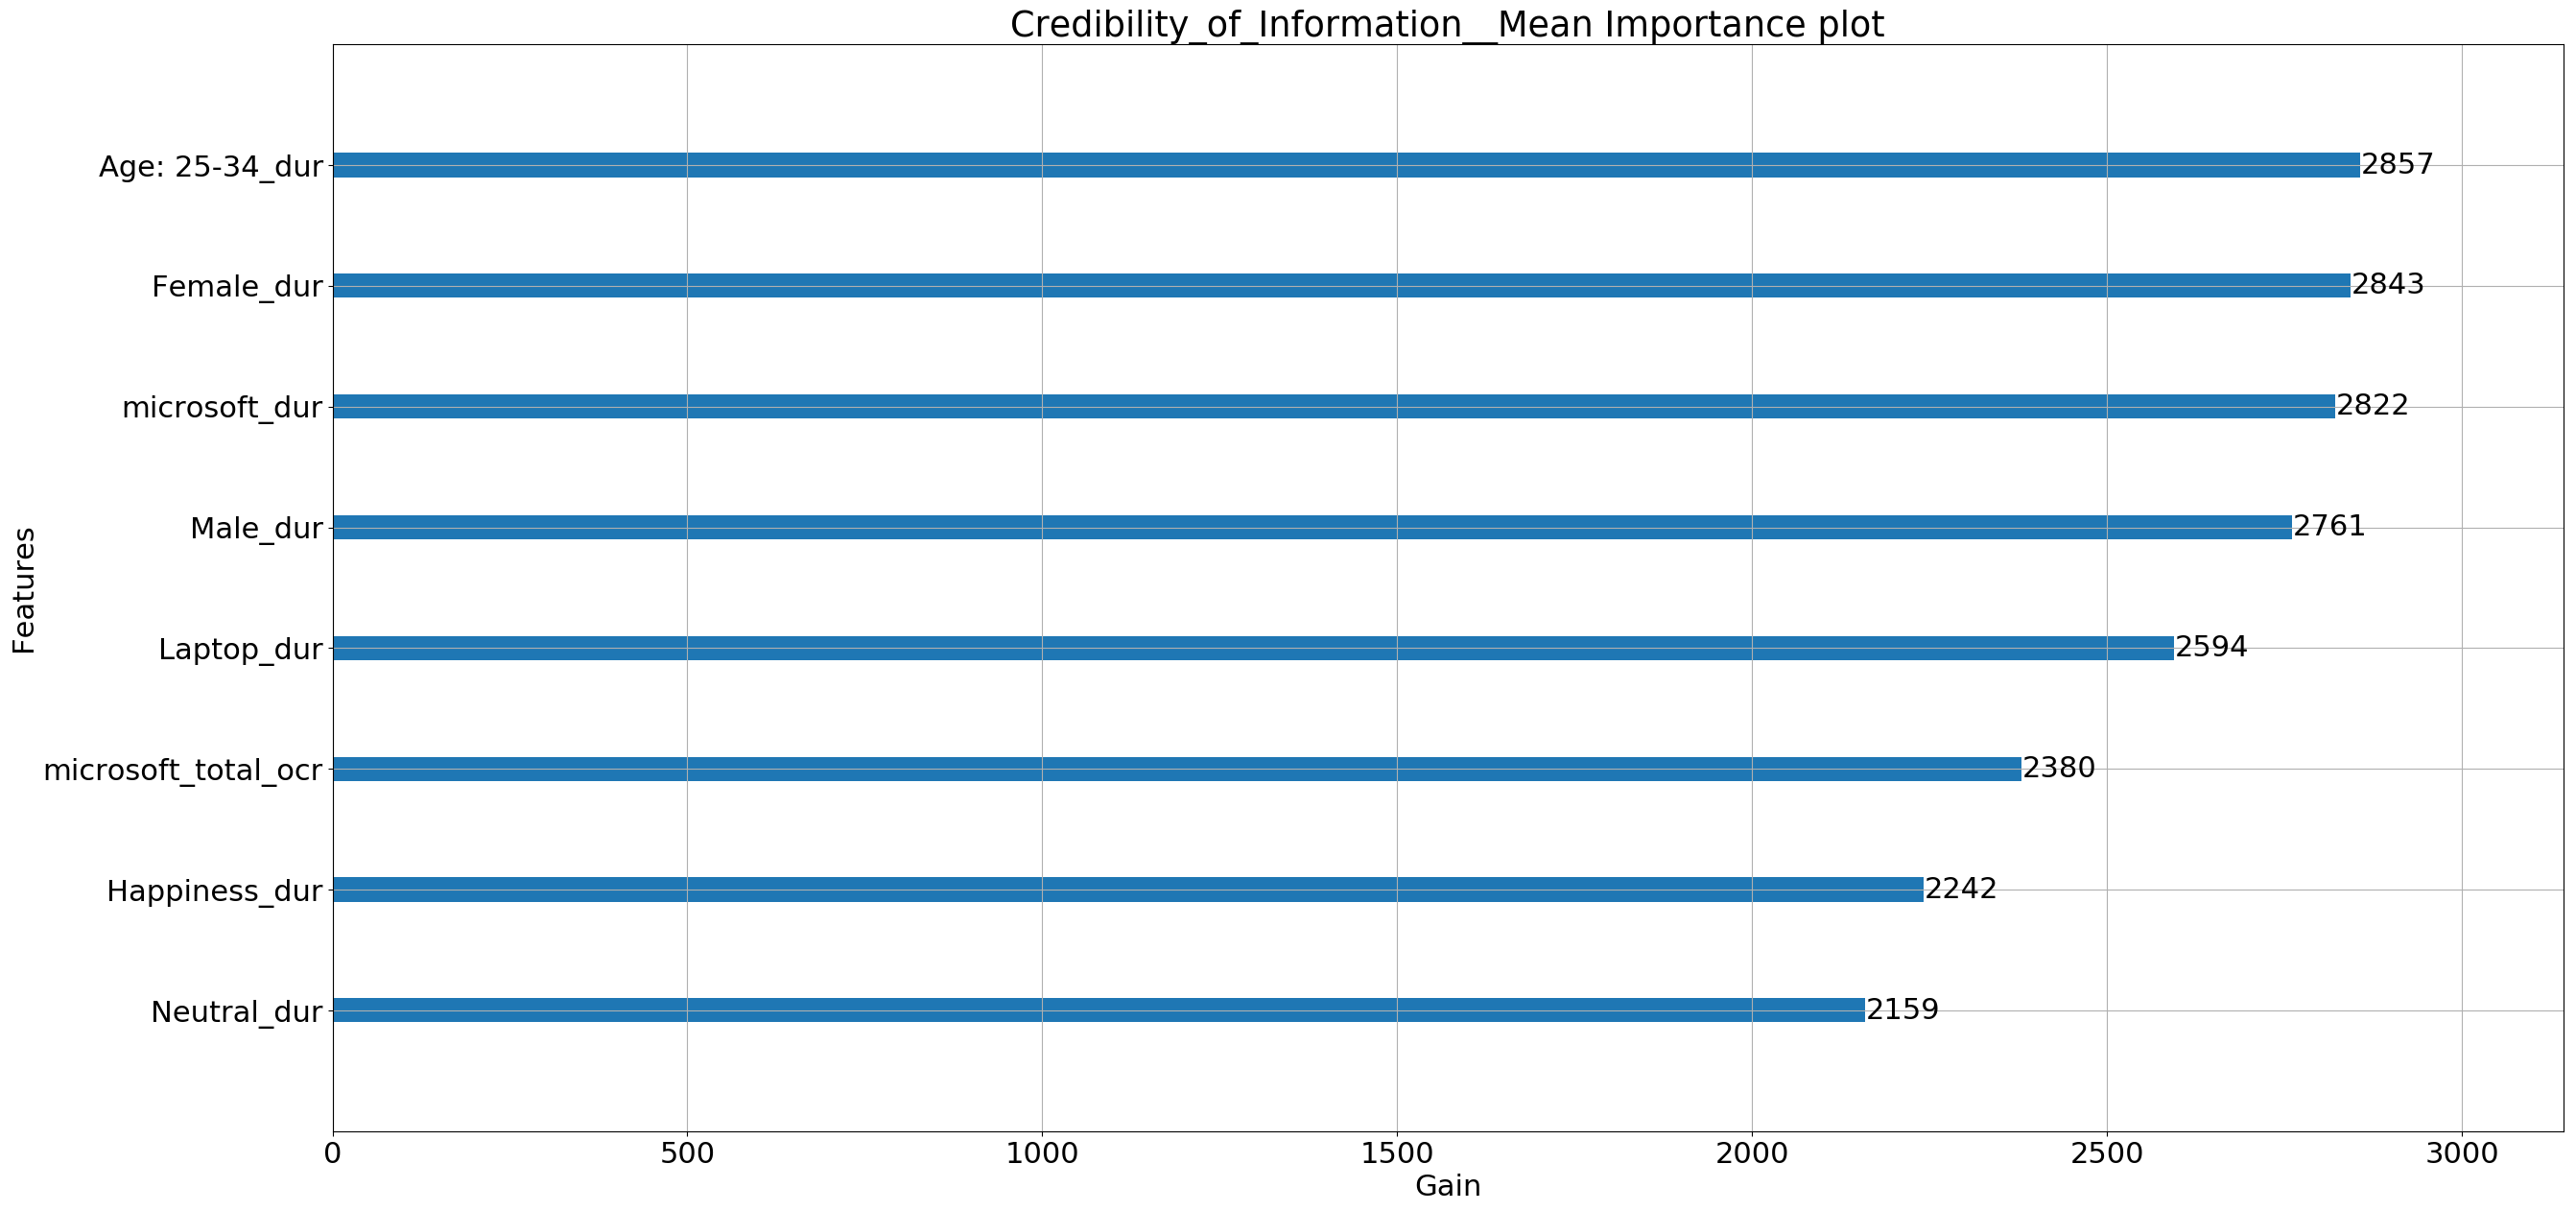

Brand_Difference__Mean
length_of_ad_15
microsoft_last_ocr
Surface_total_ocr
Tablet_first_ocr
Microsoft Surface_dur
Tablet_last_ocr
Surface_first_ocr
Surface_last_ocr
MacBook Air_dur
MacBook Pro_dur
Happiness_length_of_ad_impact
ad_type_tv
Laptop_last_ocr
Caucasian_dur
microsoft_total_ocr
Age: 25-34_Caucasian_dur
Neutral_dur
Age: 25-34_dur
Surface_dur
Tablet_total_ocr
microsoft_first_ocr
Laptop_first_ocr
Surface Book_dur
Neutral_Male_dur
Surface Laptop_dur
Age: 35-44_Eastasian_dur
Surface Go_dur
Tablet_dur
Laptop_total_ocr
Neutral_Age: 25-34_dur
Age: 25-34_Eastasian_dur
Happiness_Female_dur
Happiness_dur
African_dur
Surface laptop_dur
Laptop_dur
microsoft_dur
Happiness_Eastasian_dur
Age: 35-44_dur
Eastasian_dur
Surface Pen_dur
Sadness_dur
Male_dur
Female_dur
The surface Laptop_dur
Macbook Air_dur
Suface Laptop_dur
Dell XPS_dur
ASUS T102_dur
Windows_dur
Windows 10_dur
Windows 10 PC_dur
Windows 10 PCs_dur
Lenovo Yoga 910_dur
Lenovo Yoga 720_dur
Lenovo PCs_dur
HP Spectre x360, Windows_dur


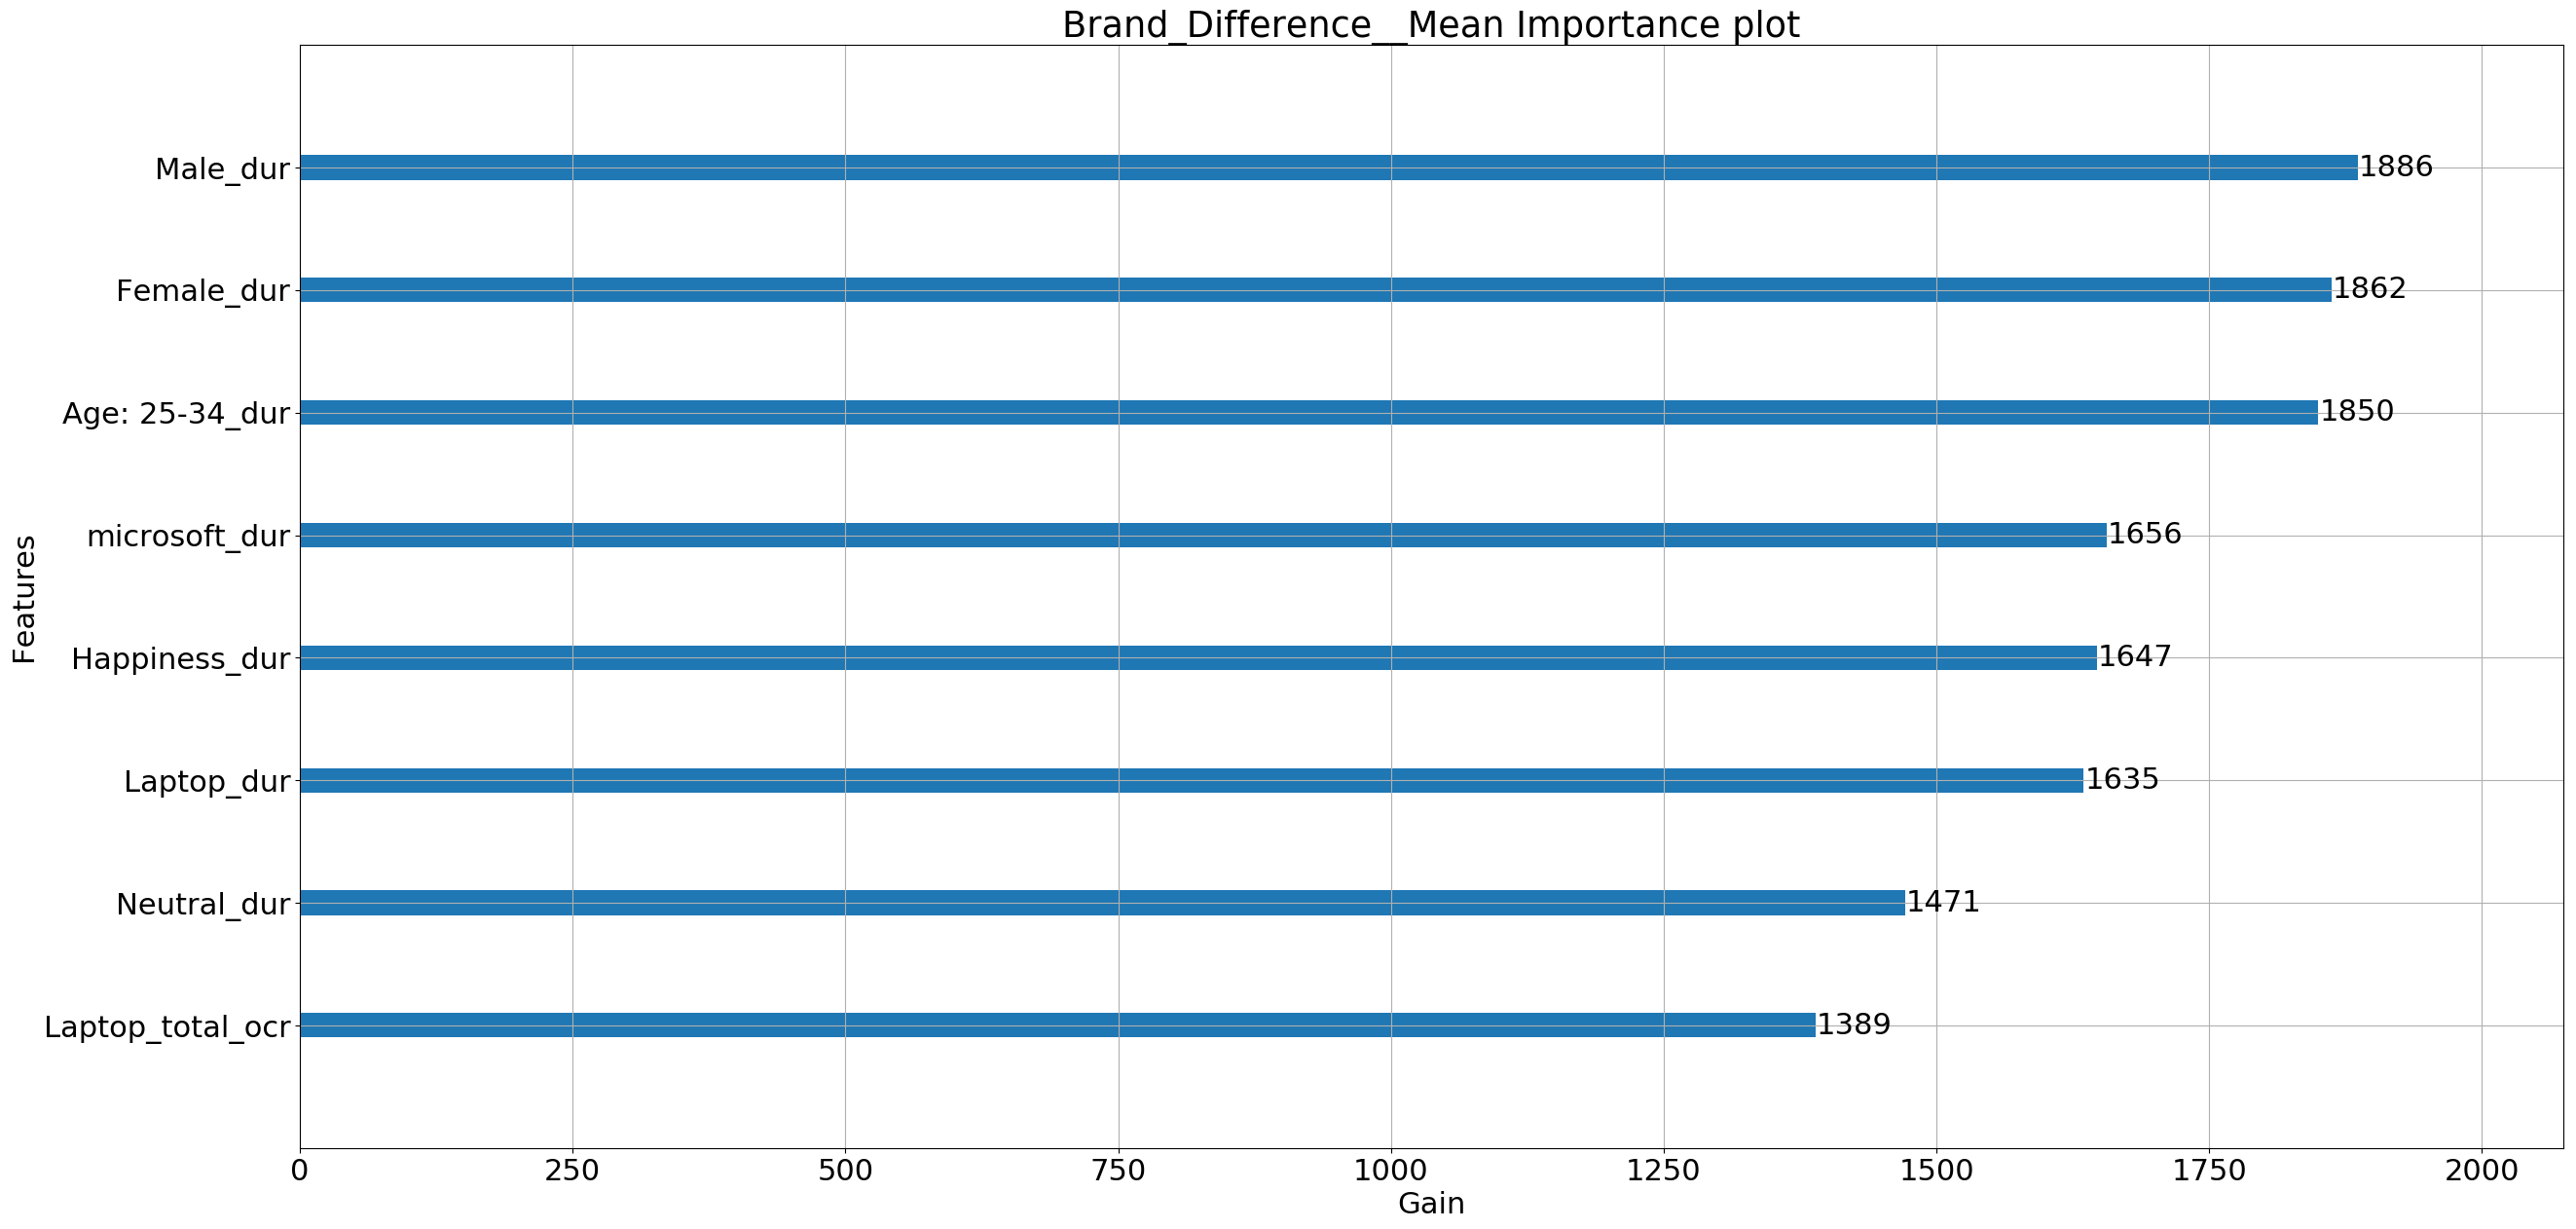

Purchase_intent
microsoft_first_ocr
Surface laptop_dur
Surface Laptop_dur
Surface_dur
Surface_first_ocr
length_of_ad_15
Surface Go_dur
Tablet_last_ocr
microsoft_total_ocr
Surface Book_dur
Laptop_total_ocr
Tablet_dur
Tablet_first_ocr
Surface_total_ocr
microsoft_last_ocr
Surface_last_ocr
Tablet_total_ocr
Age: 35-44_Eastasian_dur
Age: 25-34_Eastasian_dur
MacBook Pro_dur
Neutral_dur
Happiness_length_of_ad_impact
Laptop_last_ocr
Suface Laptop_dur
ad_type_tv
Neutral_Age: 25-34_dur
Age: 25-34_Caucasian_dur
Neutral_Male_dur
microsoft_dur
The surface Laptop_dur
Eastasian_dur
Surface Pen_dur
Happiness_Eastasian_dur
Happiness_Female_dur
Laptop_first_ocr
Happiness_dur
Female_dur
Microsoft Surface_dur
Laptop_dur
Caucasian_dur
African_dur
Sadness_dur
MacBook Air_dur
Male_dur
Age: 25-34_dur
Age: 35-44_dur
Macbook Air_dur
Yoga_dur
ASUS T102_dur
Windows_dur
Dell XPS_dur
Dell XPS 13_dur
HP Spectre x360_dur
HP Spectre x360, Windows_dur
Lenovo PCs_dur
Lenovo Yoga 720_dur
Lenovo Yoga 910_dur
Windows 10, Wi

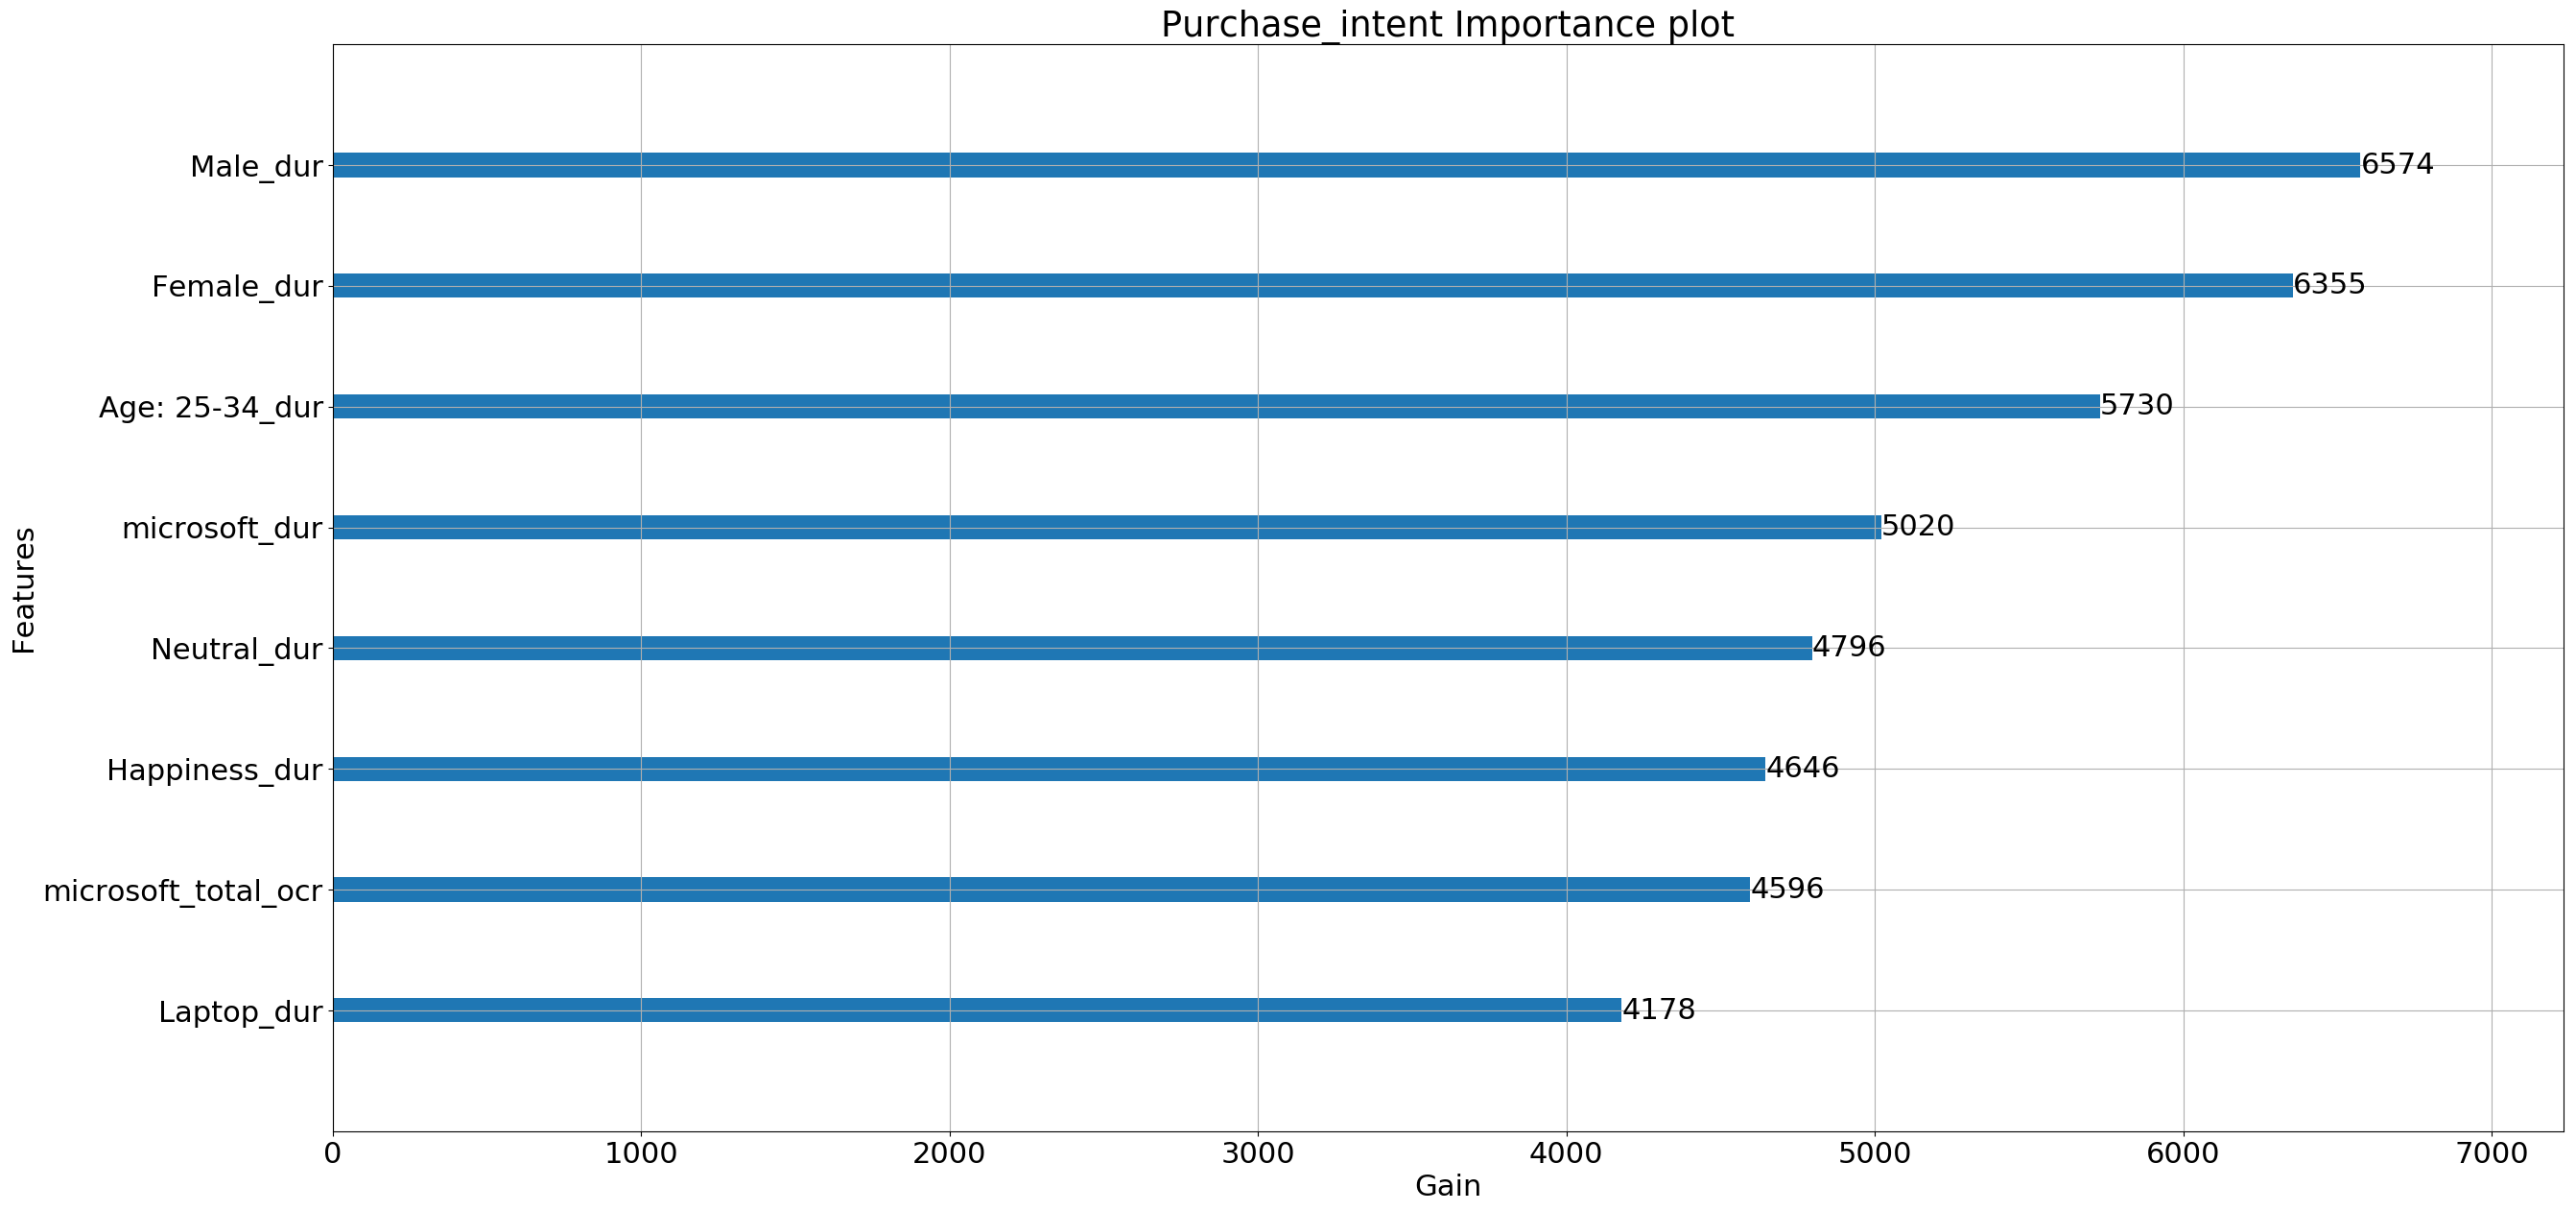

Persuasion_mean
microsoft_first_ocr
Age: 25-34_Eastasian_dur
length_of_ad_15
microsoft_total_ocr
Tablet_dur
Neutral_Age: 25-34_dur
Surface laptop_dur
Caucasian_dur
Neutral_dur
Tablet_total_ocr
Laptop_total_ocr
Surface Go_dur
Tablet_last_ocr
Age: 35-44_Eastasian_dur
Laptop_last_ocr
Age: 25-34_Caucasian_dur
Laptop_dur
microsoft_last_ocr
microsoft_dur
Surface_dur
Laptop_first_ocr
Happiness_length_of_ad_impact
Neutral_Male_dur
Tablet_first_ocr
Surface_last_ocr
Sadness_dur
Surface Laptop_dur
Eastasian_dur
Happiness_Eastasian_dur
Age: 25-34_dur
Female_dur
Happiness_dur
Happiness_Female_dur
African_dur
Male_dur
Age: 35-44_dur
MacBook Air_dur
Surface_first_ocr
Surface_total_ocr
Surface Book_dur
Suface Laptop_dur
ad_type_tv
Microsoft Surface_dur
The surface Laptop_dur
Surface Pen_dur
Macbook Air_dur
MacBook Pro_dur
Lenovo Yoga 910_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
HP Spectre x360, Windows_dur
HP Spectre x360_dur
Windows 10_dur
W

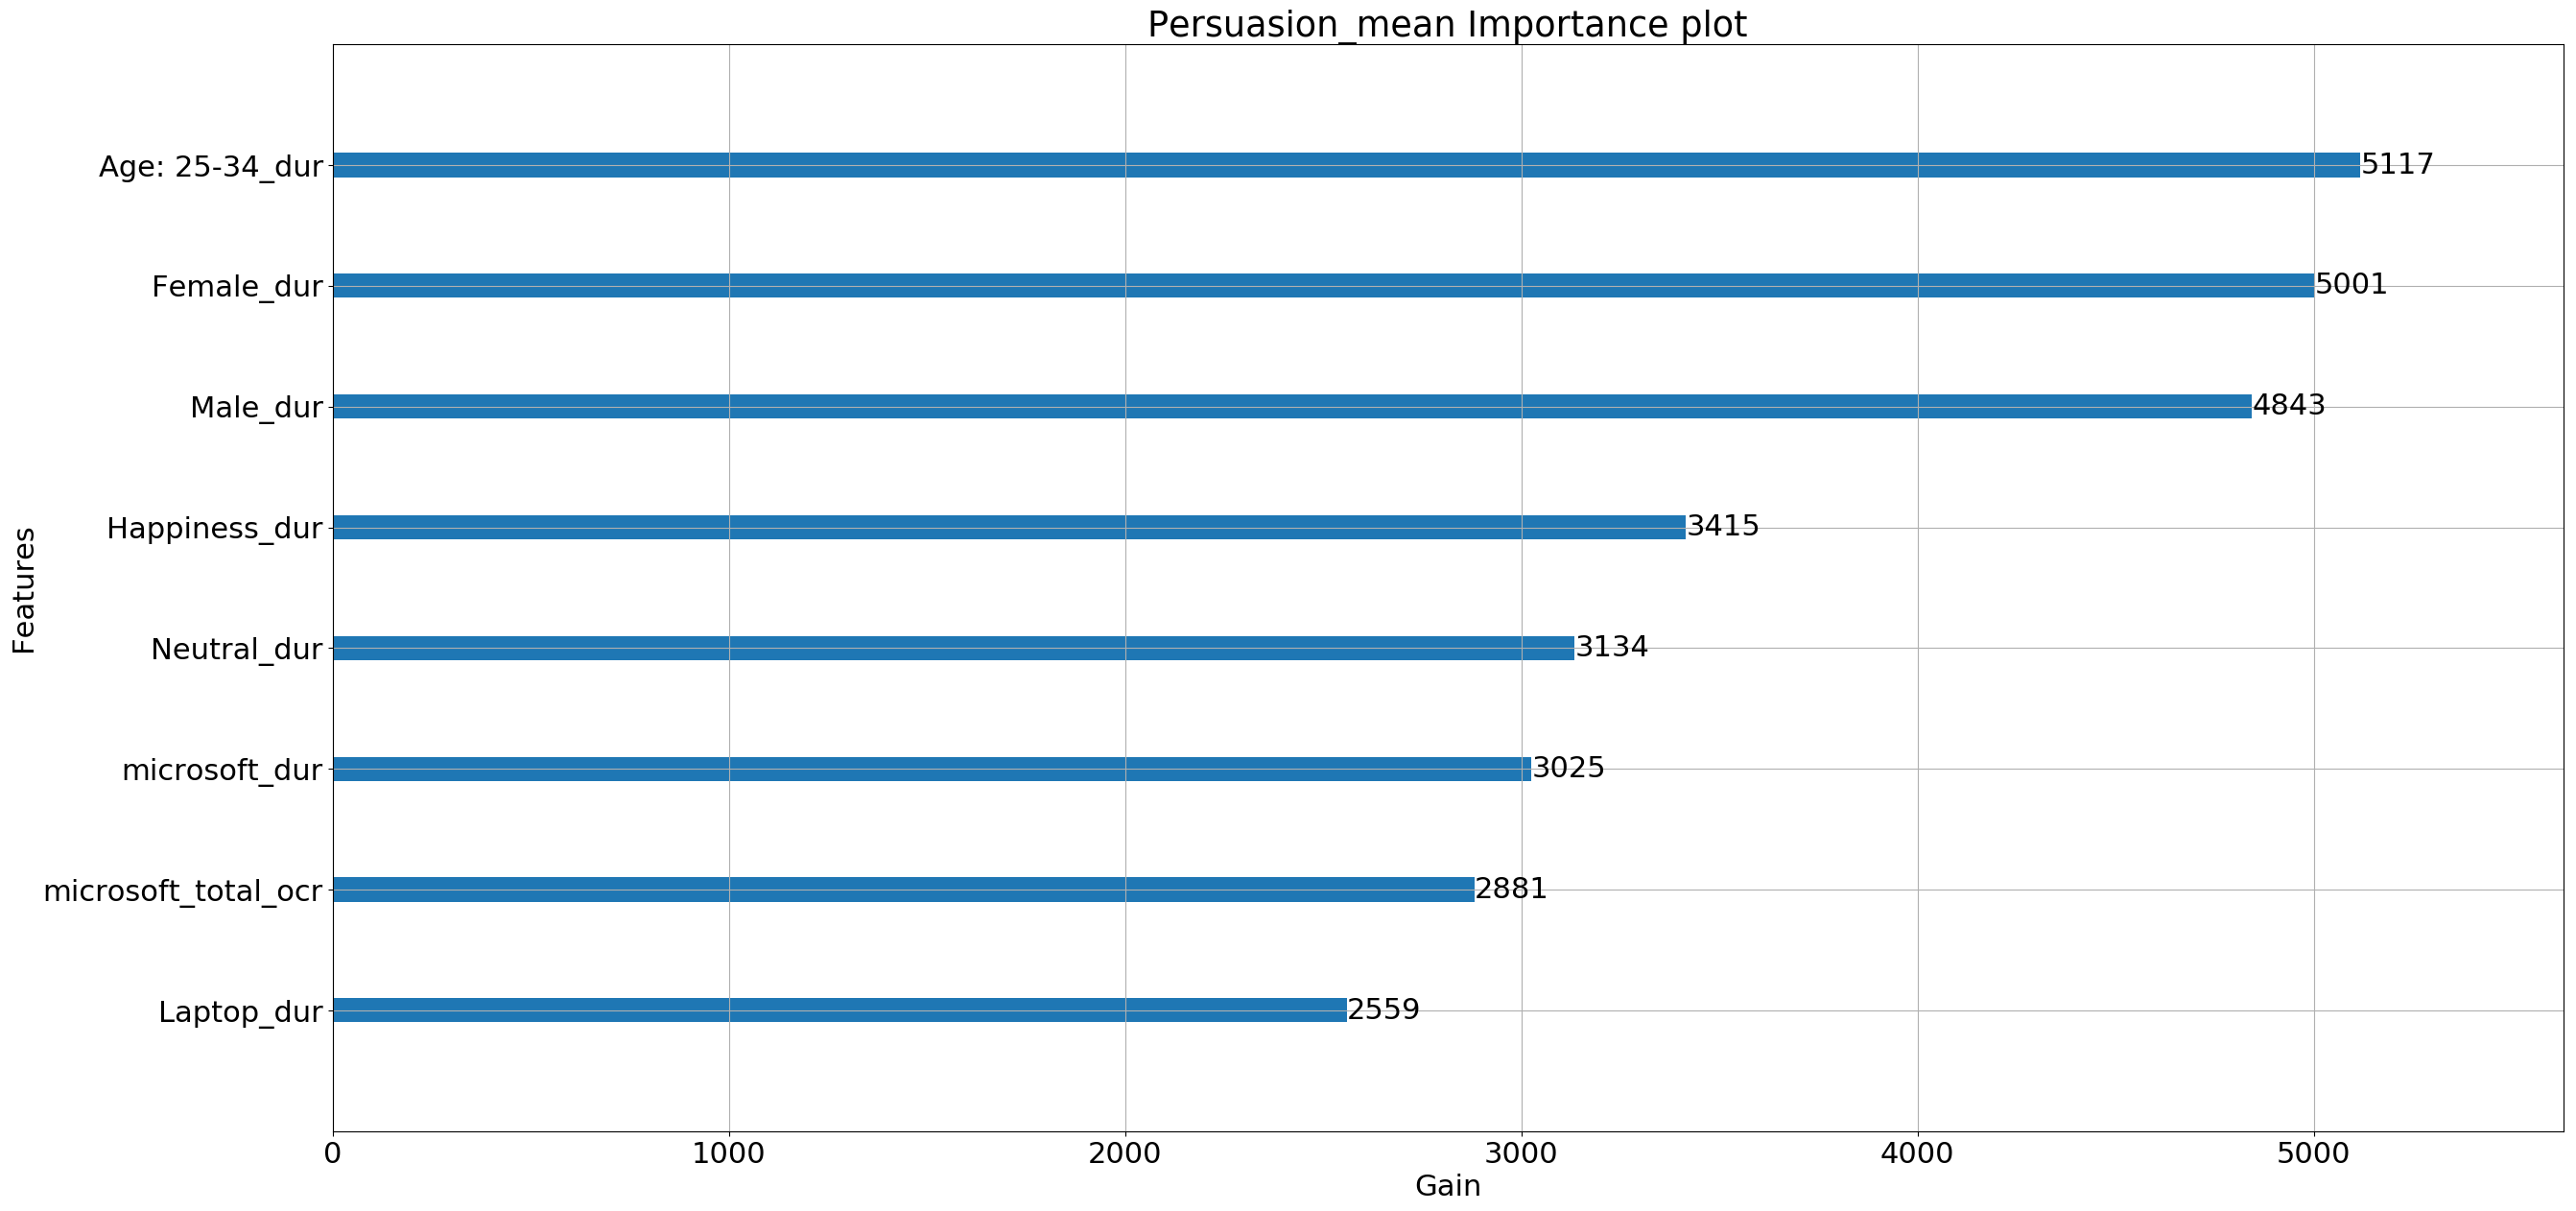

Persuasion_very_likely
Age: 25-34_Eastasian_dur
microsoft_first_ocr
microsoft_total_ocr
length_of_ad_15
Tablet_total_ocr
Neutral_Age: 25-34_dur
Tablet_dur
Laptop_total_ocr
Surface laptop_dur
Laptop_last_ocr
Neutral_dur
Caucasian_dur
Surface_dur
Tablet_last_ocr
microsoft_dur
Surface_total_ocr
Laptop_dur
Neutral_Male_dur
Age: 25-34_Caucasian_dur
Surface Go_dur
Laptop_first_ocr
The surface Laptop_dur
microsoft_last_ocr
Happiness_length_of_ad_impact
Surface_last_ocr
Tablet_first_ocr
Surface_first_ocr
Age: 35-44_Eastasian_dur
Sadness_dur
Eastasian_dur
Surface Laptop_dur
Happiness_Eastasian_dur
Age: 25-34_dur
Surface Book_dur
Surface Pen_dur
MacBook Air_dur
Happiness_dur
Female_dur
Happiness_Female_dur
Male_dur
MacBook Pro_dur
African_dur
Age: 35-44_dur
Suface Laptop_dur
ad_type_tv
Macbook Air_dur
Microsoft Surface_dur
Yoga_dur
ASUS T102_dur
Dell PCs_dur
Dell XPS_dur
Dell XPS 13_dur
HP Spectre x360_dur
Windows 10, Windows_dur
Lenovo PCs_dur
Lenovo Yoga 720_dur
Lenovo Yoga 910_dur
Windows_dur

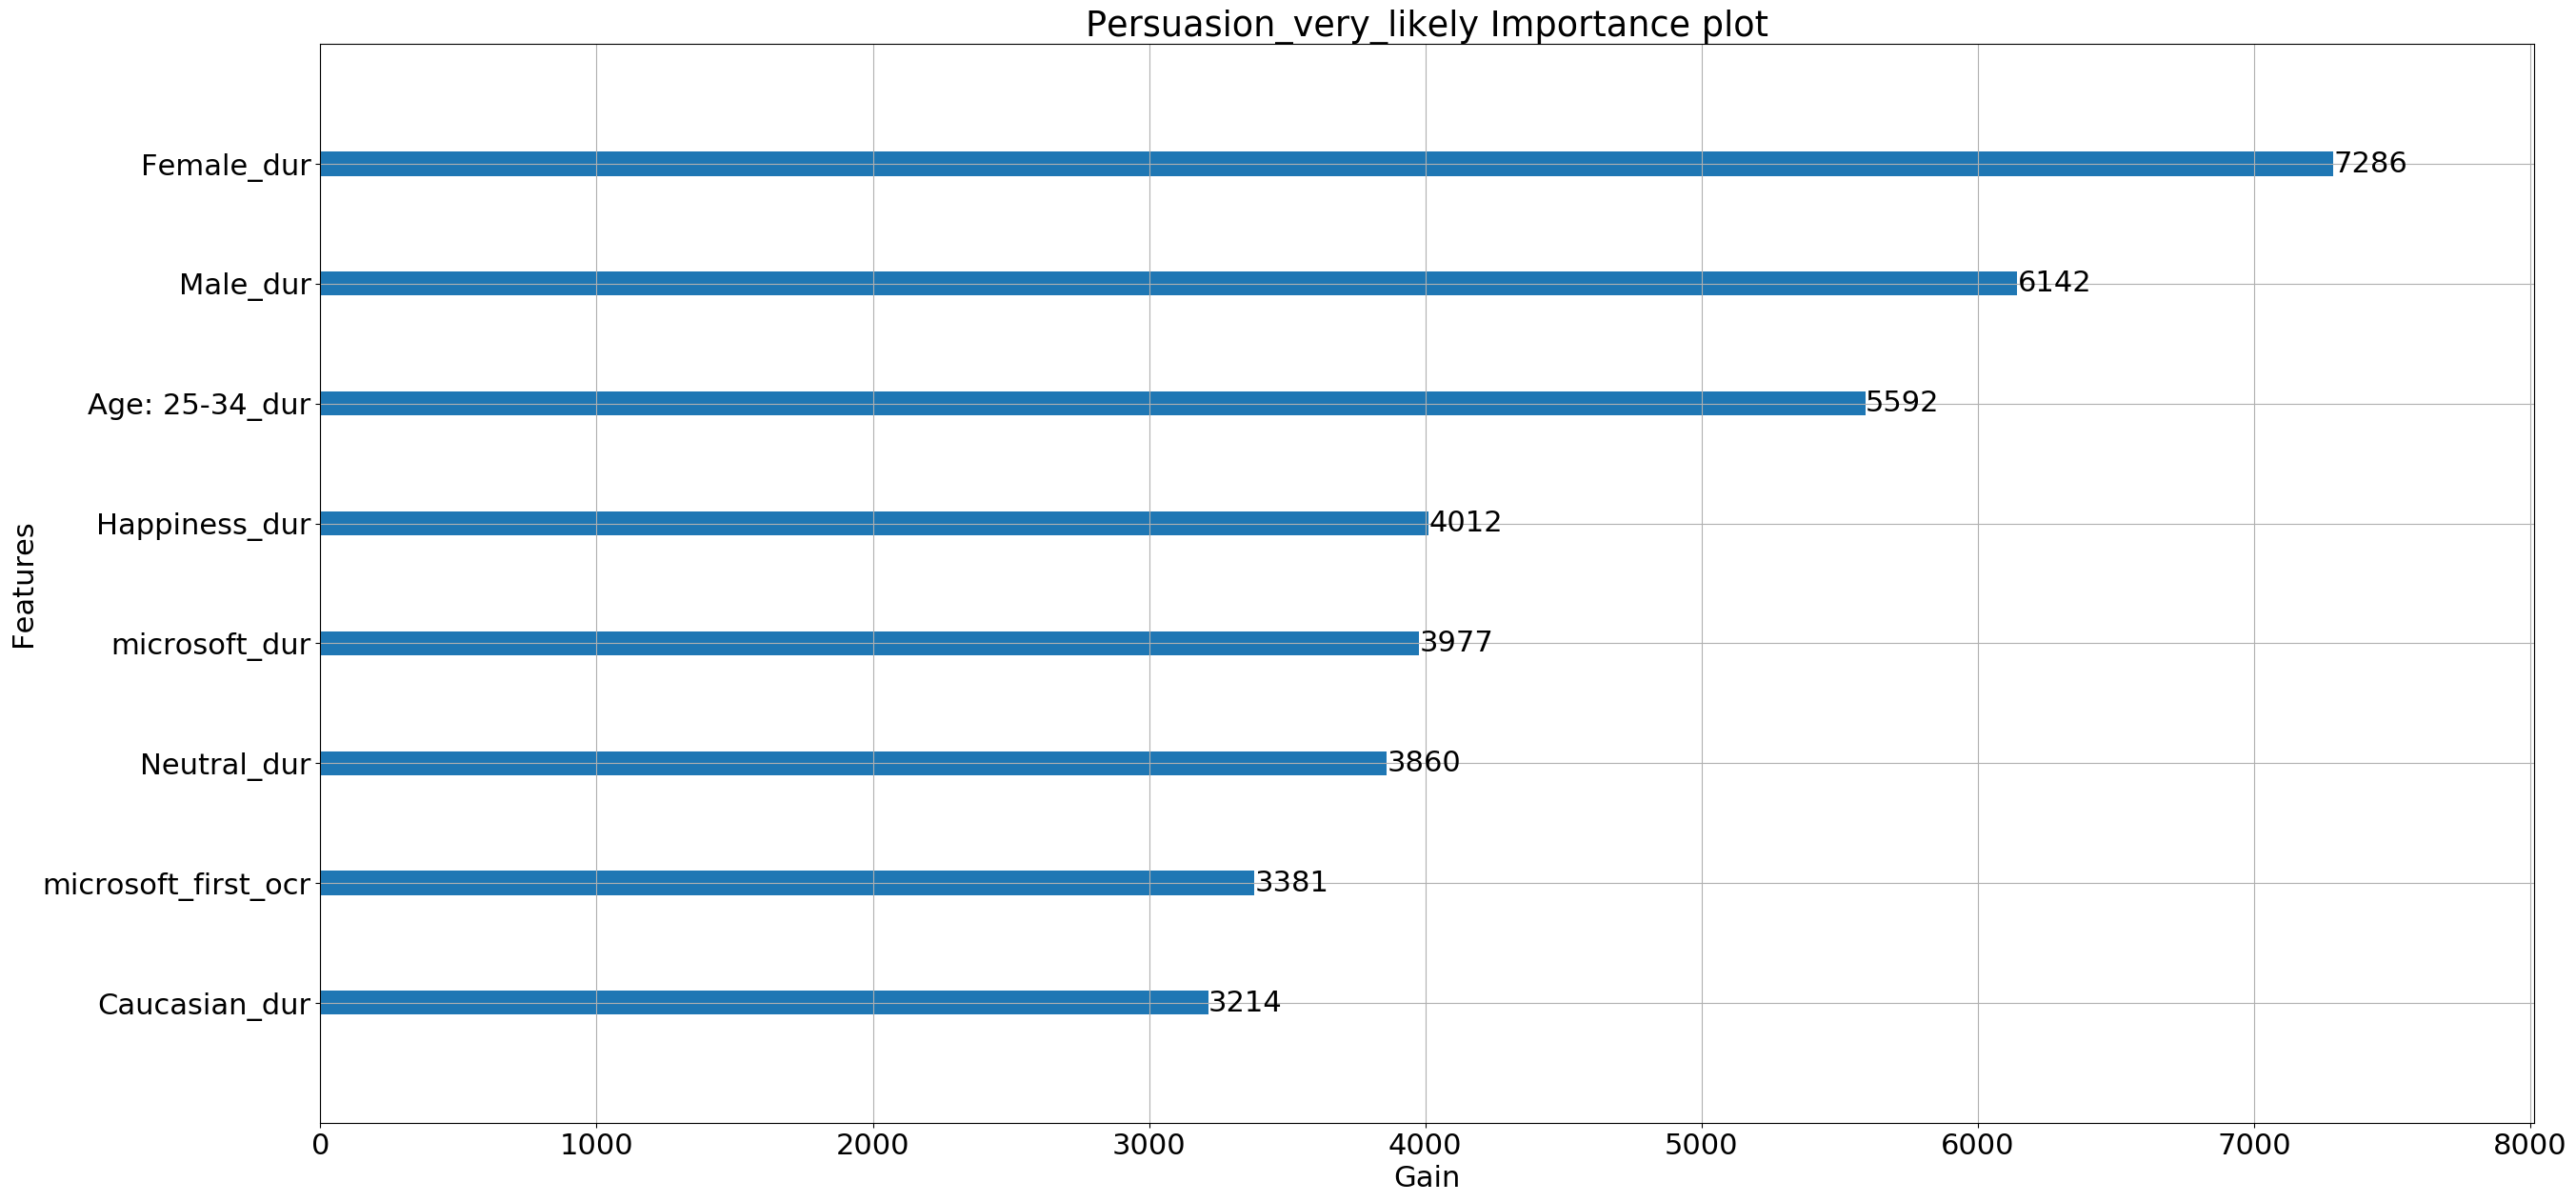

In [23]:
model.plot_feature_importance(models_14,10,y_train_14.columns,X_train_14.columns,savefig=False)

Unaided_Branding
Laptop_first_ocr
microsoft_first_ocr
Age: 25-34_Eastasian_dur
Surface_total_ocr
Tablet_last_ocr
Happiness_length_of_ad_impact
microsoft_dur
Happiness_Eastasian_dur
Surface Book_dur
Happiness_dur
Laptop_total_ocr
Tablet_dur
Surface_last_ocr
length_of_ad_15
Surface_dur
Neutral_Age: 25-34_dur
Laptop_last_ocr
microsoft_total_ocr
Age: 25-34_Caucasian_dur
African_dur
Age: 25-34_dur
Caucasian_dur
Sadness_dur
Happiness_Female_dur
Age: 35-44_Eastasian_dur
Surface_first_ocr
microsoft_last_ocr
Tablet_first_ocr
Laptop_dur
Neutral_Male_dur
Tablet_total_ocr
Male_dur
Female_dur
Eastasian_dur
Age: 35-44_dur
Neutral_dur
Surface Pen_dur
Macbook Air_dur
MacBook Pro_dur
MacBook Air_dur
ad_type_tv
Dell XPS_dur
ASUS T102_dur
Dell PCs_dur
Lenovo Yoga 910_dur
Dell XPS 13_dur
HP Spectre x360_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
Windows 10_dur
Windows_dur
The surface Laptop_dur
Surface laptop_dur
Surface Laptop_dur
Suface Laptop_du

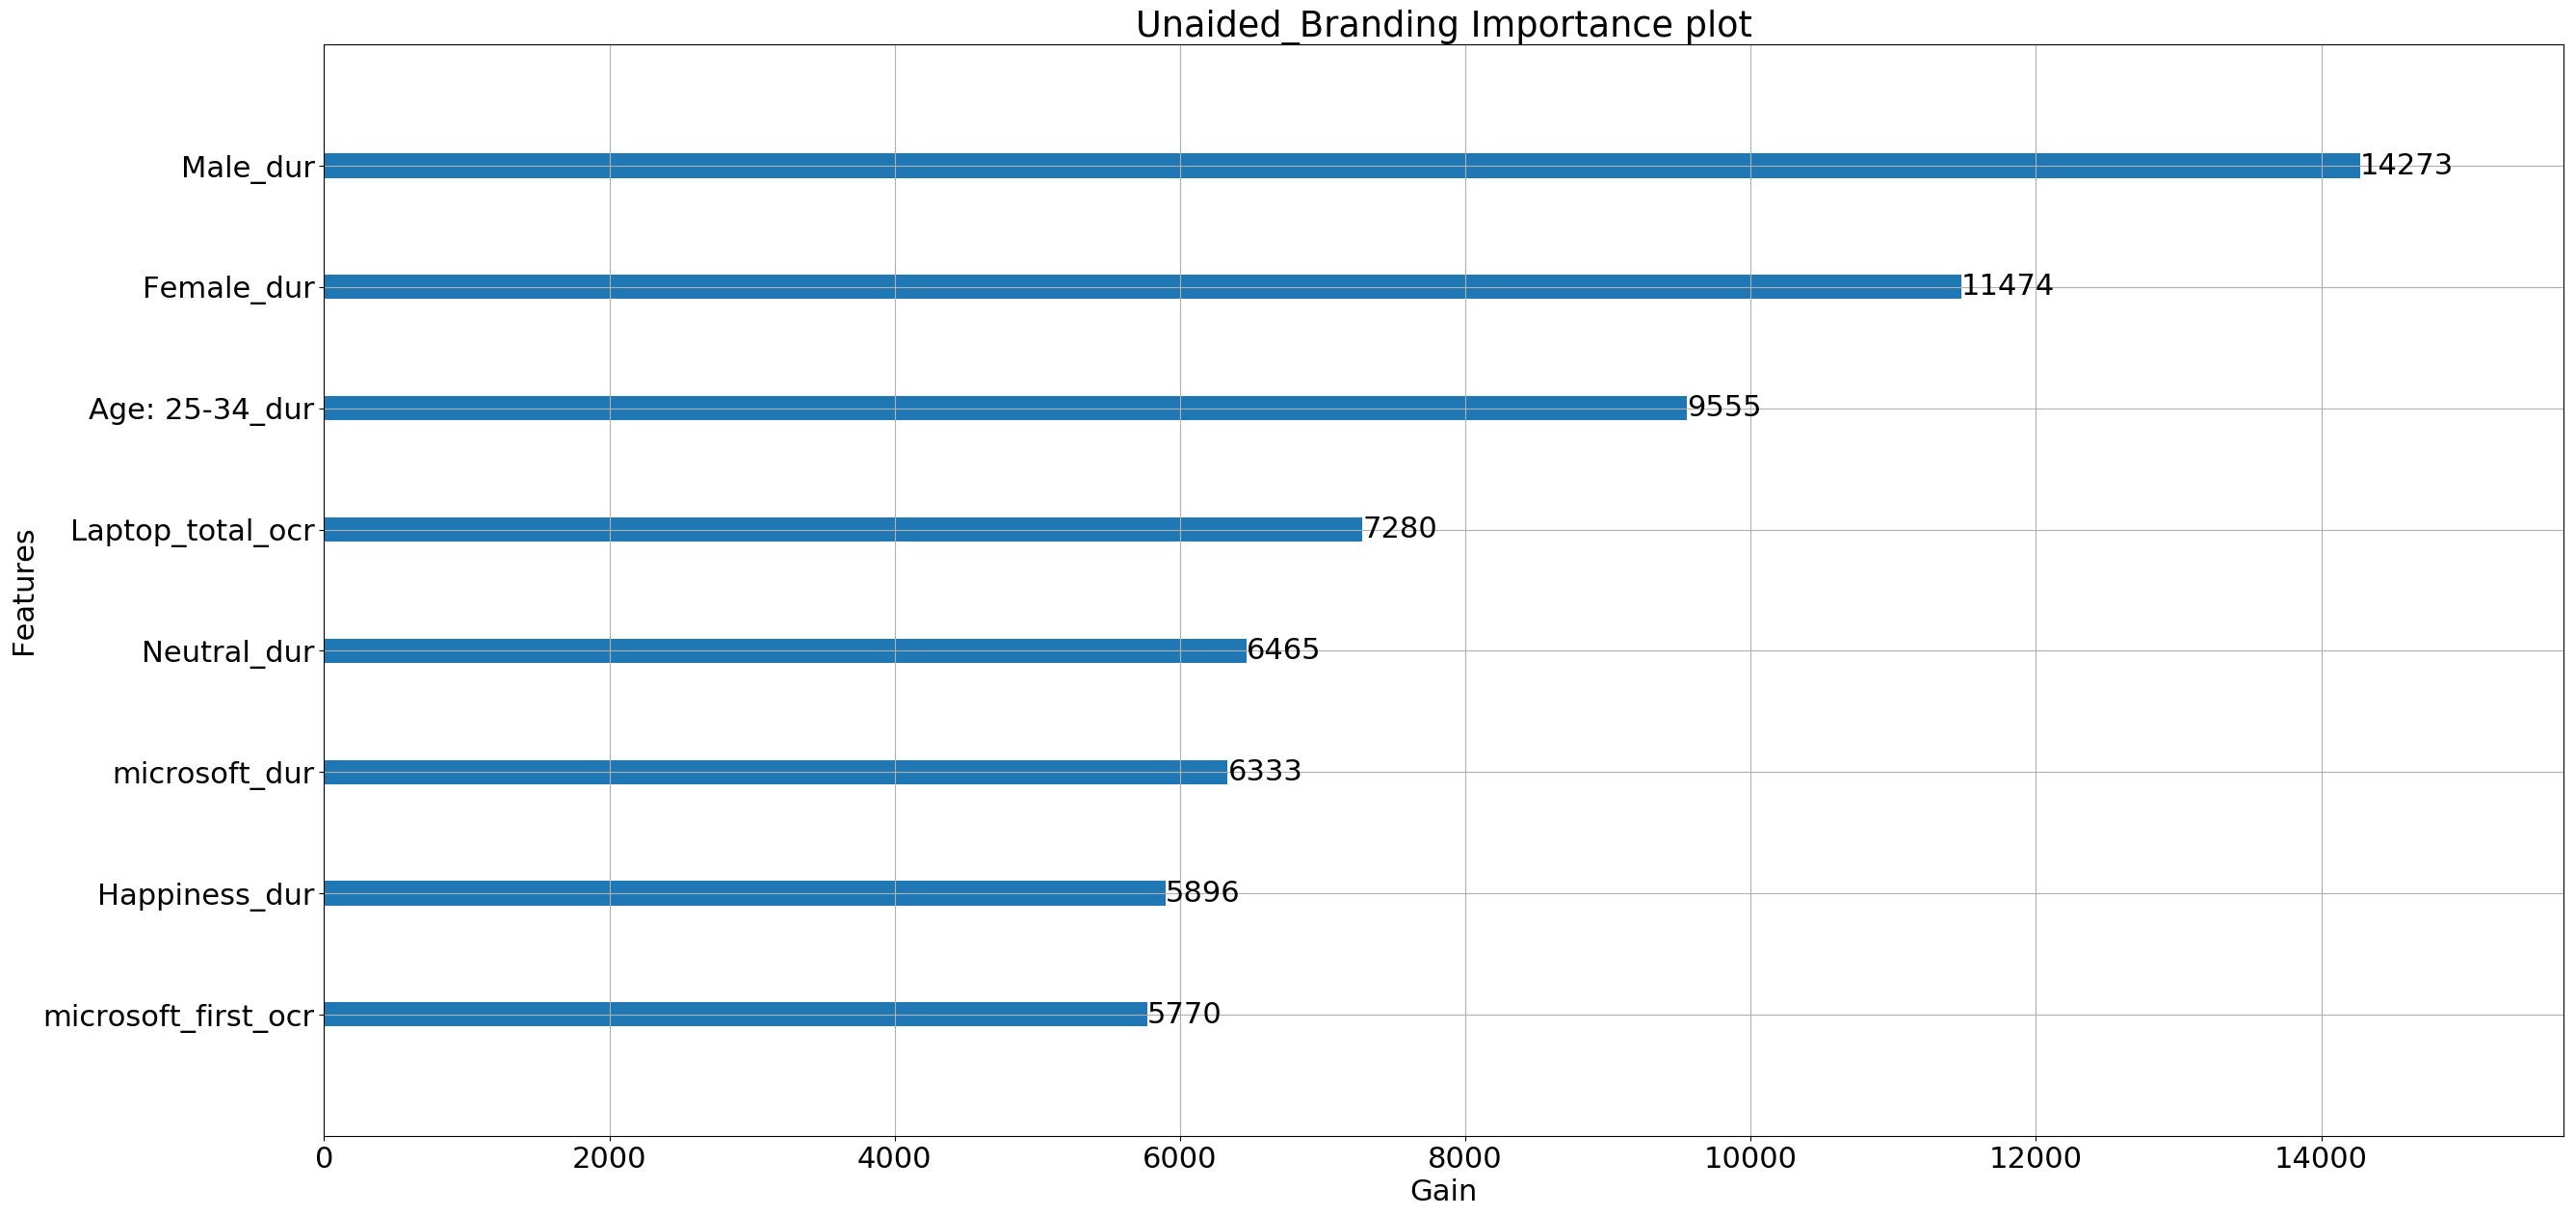

Interest_peak
Macbook Air_dur
Happiness_Female_dur
length_of_ad_15
Surface_total_ocr
Surface Book_dur
Neutral_Male_dur
Neutral_Age: 25-34_dur
Age: 25-34_Caucasian_dur
Surface Pen_dur
Happiness_length_of_ad_impact
Laptop_last_ocr
Surface_dur
Tablet_last_ocr
Surface_first_ocr
MacBook Pro_dur
African_dur
microsoft_last_ocr
Age: 25-34_Eastasian_dur
Surface_last_ocr
Happiness_dur
Laptop_total_ocr
microsoft_total_ocr
Tablet_first_ocr
Happiness_Eastasian_dur
Tablet_dur
Caucasian_dur
Age: 35-44_Eastasian_dur
Neutral_dur
microsoft_first_ocr
Female_dur
Age: 25-34_dur
Tablet_total_ocr
Laptop_dur
microsoft_dur
Eastasian_dur
ad_type_tv
Male_dur
Sadness_dur
Age: 35-44_dur
MacBook Air_dur
Laptop_first_ocr
Windows 10 PC_dur
Dell PCs_dur
ASUS T102_dur
Dell XPS 13_dur
Dell XPS_dur
Windows 10_dur
Windows_dur
The surface Laptop_dur
Surface laptop_dur
Surface Laptop_dur
Windows 10 PCs_dur
Windows 10, HP_Spectre_dur
Suface Laptop_dur
Microsoft Surface_dur
Windows 10, Windows_dur
Yoga_dur
Lenovo Yoga 910_dur

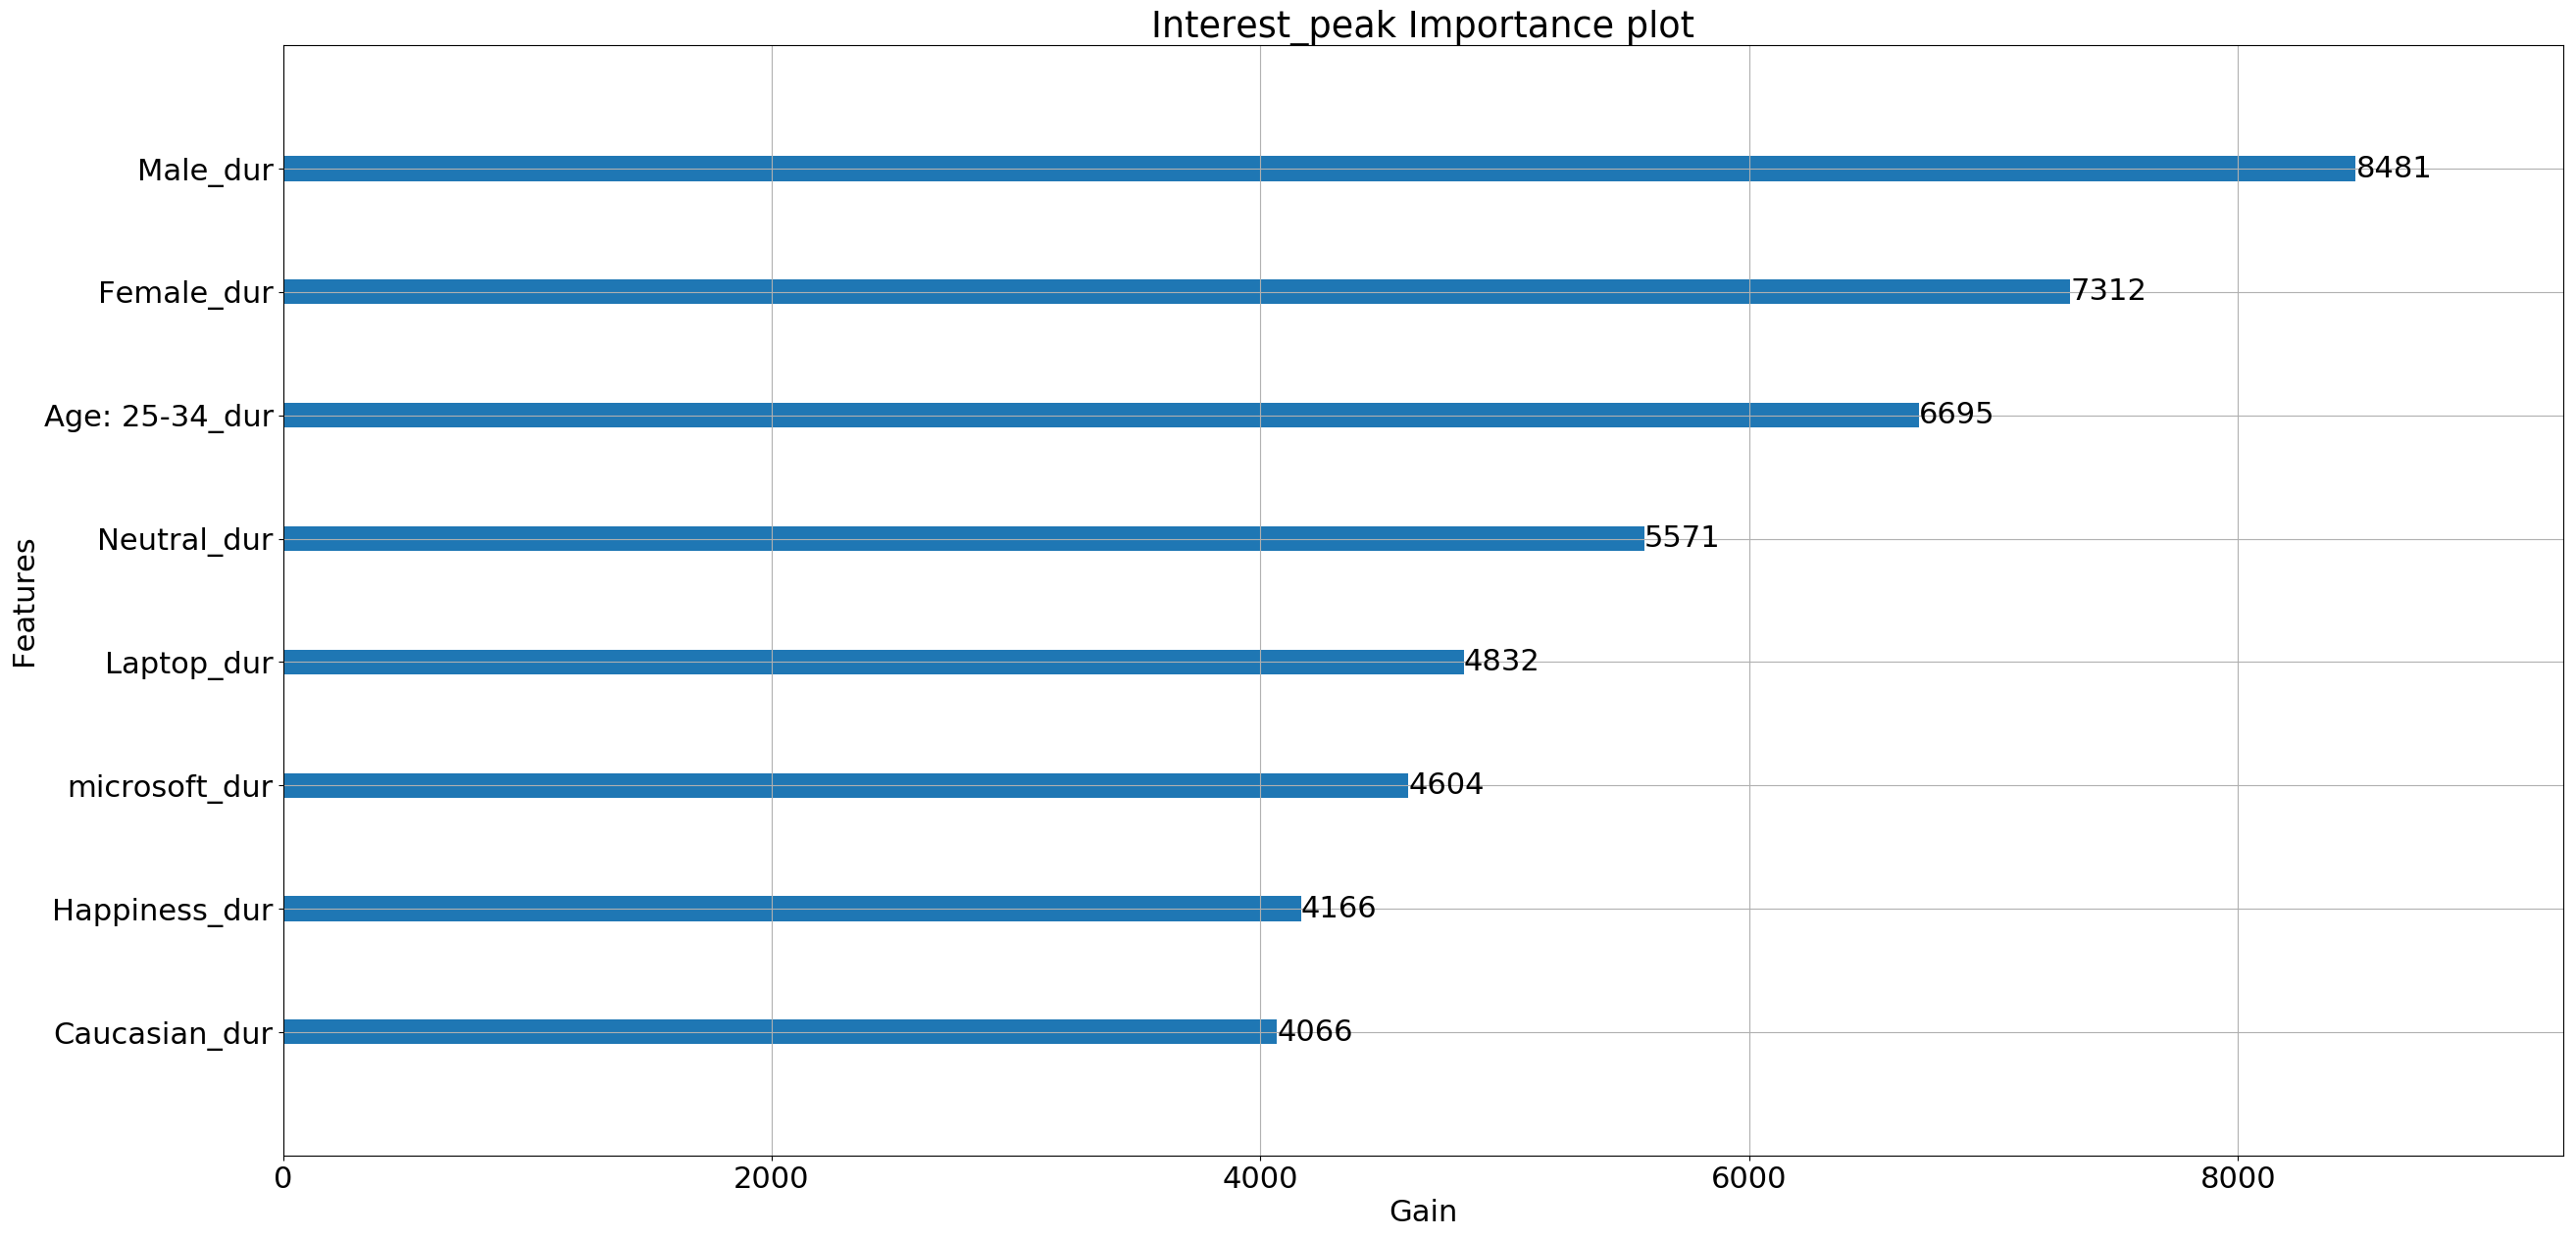

Interest_mean_score
length_of_ad_15
Surface_dur
Surface_total_ocr
microsoft_first_ocr
microsoft_last_ocr
Surface_first_ocr
MacBook Air_dur
Surface Book_dur
Laptop_last_ocr
Age: 25-34_dur
Neutral_Male_dur
Macbook Air_dur
Laptop_total_ocr
MacBook Pro_dur
Tablet_last_ocr
Neutral_dur
Surface_last_ocr
Sadness_dur
Laptop_first_ocr
Caucasian_dur
Tablet_dur
Happiness_length_of_ad_impact
microsoft_dur
Surface Pen_dur
Age: 35-44_Eastasian_dur
Eastasian_dur
ad_type_tv
African_dur
Laptop_dur
Happiness_dur
Neutral_Age: 25-34_dur
Tablet_total_ocr
Happiness_Eastasian_dur
microsoft_total_ocr
Tablet_first_ocr
Happiness_Female_dur
Male_dur
Age: 25-34_Caucasian_dur
Age: 25-34_Eastasian_dur
Female_dur
Age: 35-44_dur
Windows 10, HP_Spectre_dur
Dell PCs_dur
ASUS T102_dur
HP Spectre x360_dur
Dell XPS_dur
Dell XPS 13_dur
Windows 10 PC_dur
Windows 10_dur
Windows_dur
The surface Laptop_dur
Surface laptop_dur
Surface Laptop_dur
Windows 10, Windows_dur
Yoga_dur
Suface Laptop_dur
Microsoft Surface_dur
Lenovo Yoga 

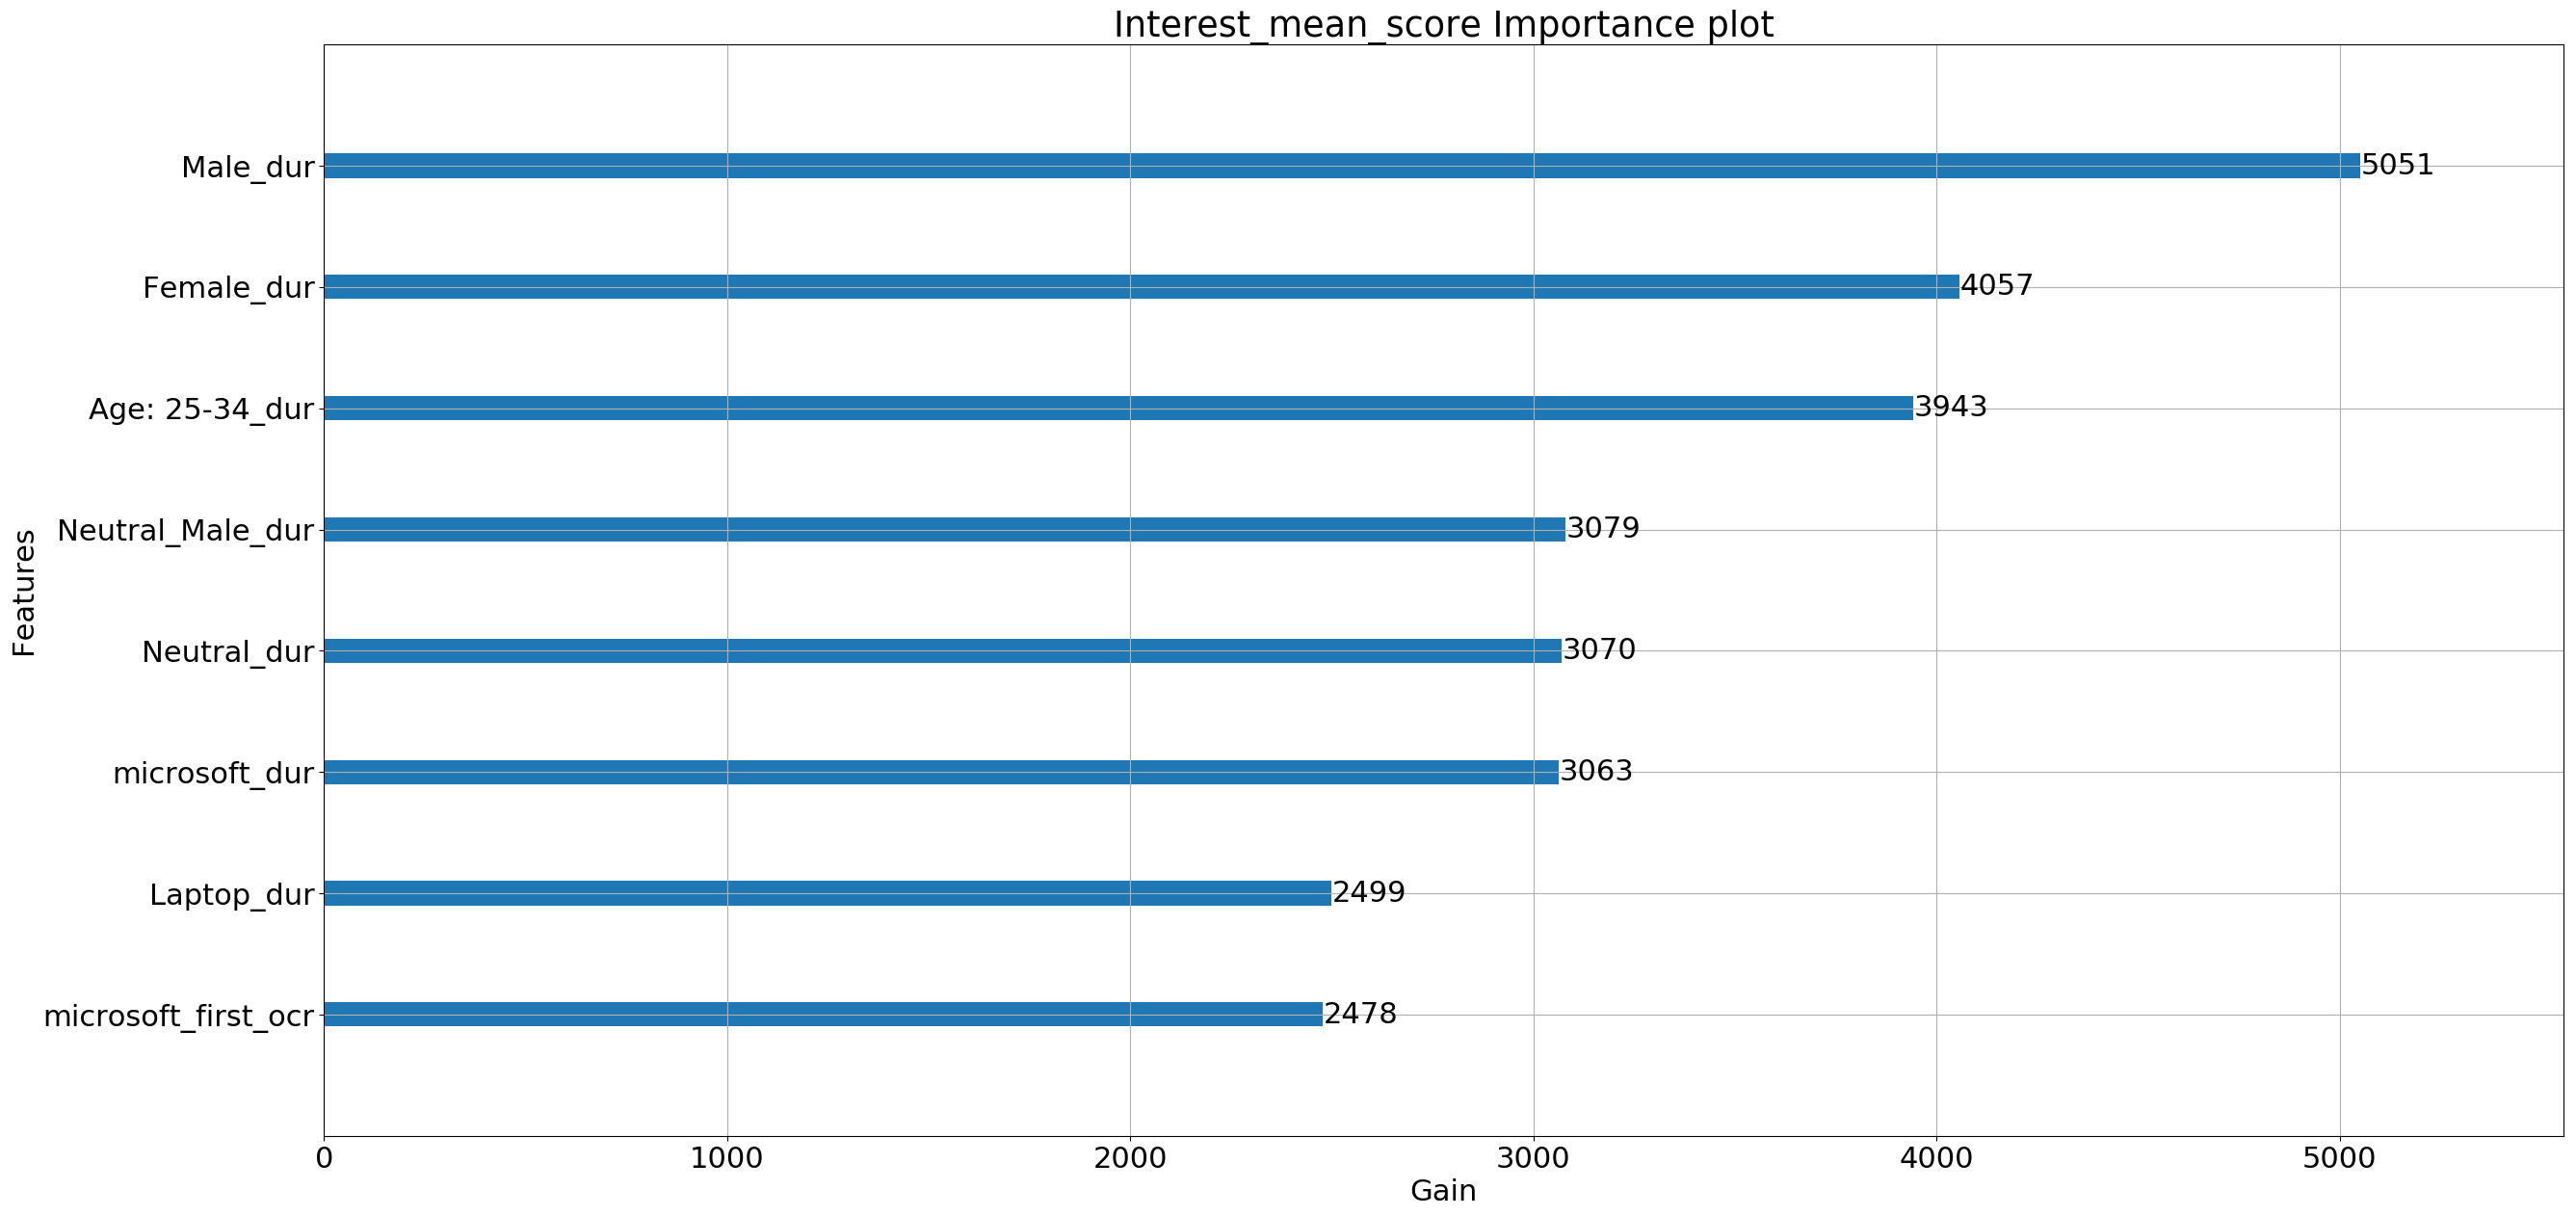

Interest_peak_frames
Macbook Air_dur
Happiness_Female_dur
Neutral_Male_dur
Tablet_total_ocr
Tablet_last_ocr
Laptop_last_ocr
Neutral_Age: 25-34_dur
Surface_first_ocr
Age: 25-34_Caucasian_dur
Surface_last_ocr
Happiness_length_of_ad_impact
Surface Pen_dur
Surface_total_ocr
Tablet_dur
microsoft_last_ocr
length_of_ad_15
Happiness_dur
microsoft_total_ocr
African_dur
Caucasian_dur
Surface_dur
Surface Book_dur
Age: 25-34_Eastasian_dur
Tablet_first_ocr
Age: 35-44_Eastasian_dur
Laptop_total_ocr
microsoft_first_ocr
Laptop_dur
Female_dur
Laptop_first_ocr
Happiness_Eastasian_dur
Age: 25-34_dur
microsoft_dur
Age: 35-44_dur
Neutral_dur
MacBook Pro_dur
Eastasian_dur
Sadness_dur
Male_dur
ad_type_tv
MacBook Air_dur
Dell XPS_dur
ASUS T102_dur
Dell PCs_dur
Lenovo Yoga 720_dur
Dell XPS 13_dur
HP Spectre x360_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
Windows 10_dur
Windows_dur
The surface Laptop_dur
Surface laptop_dur
Surface Laptop_dur
Suface Lapto

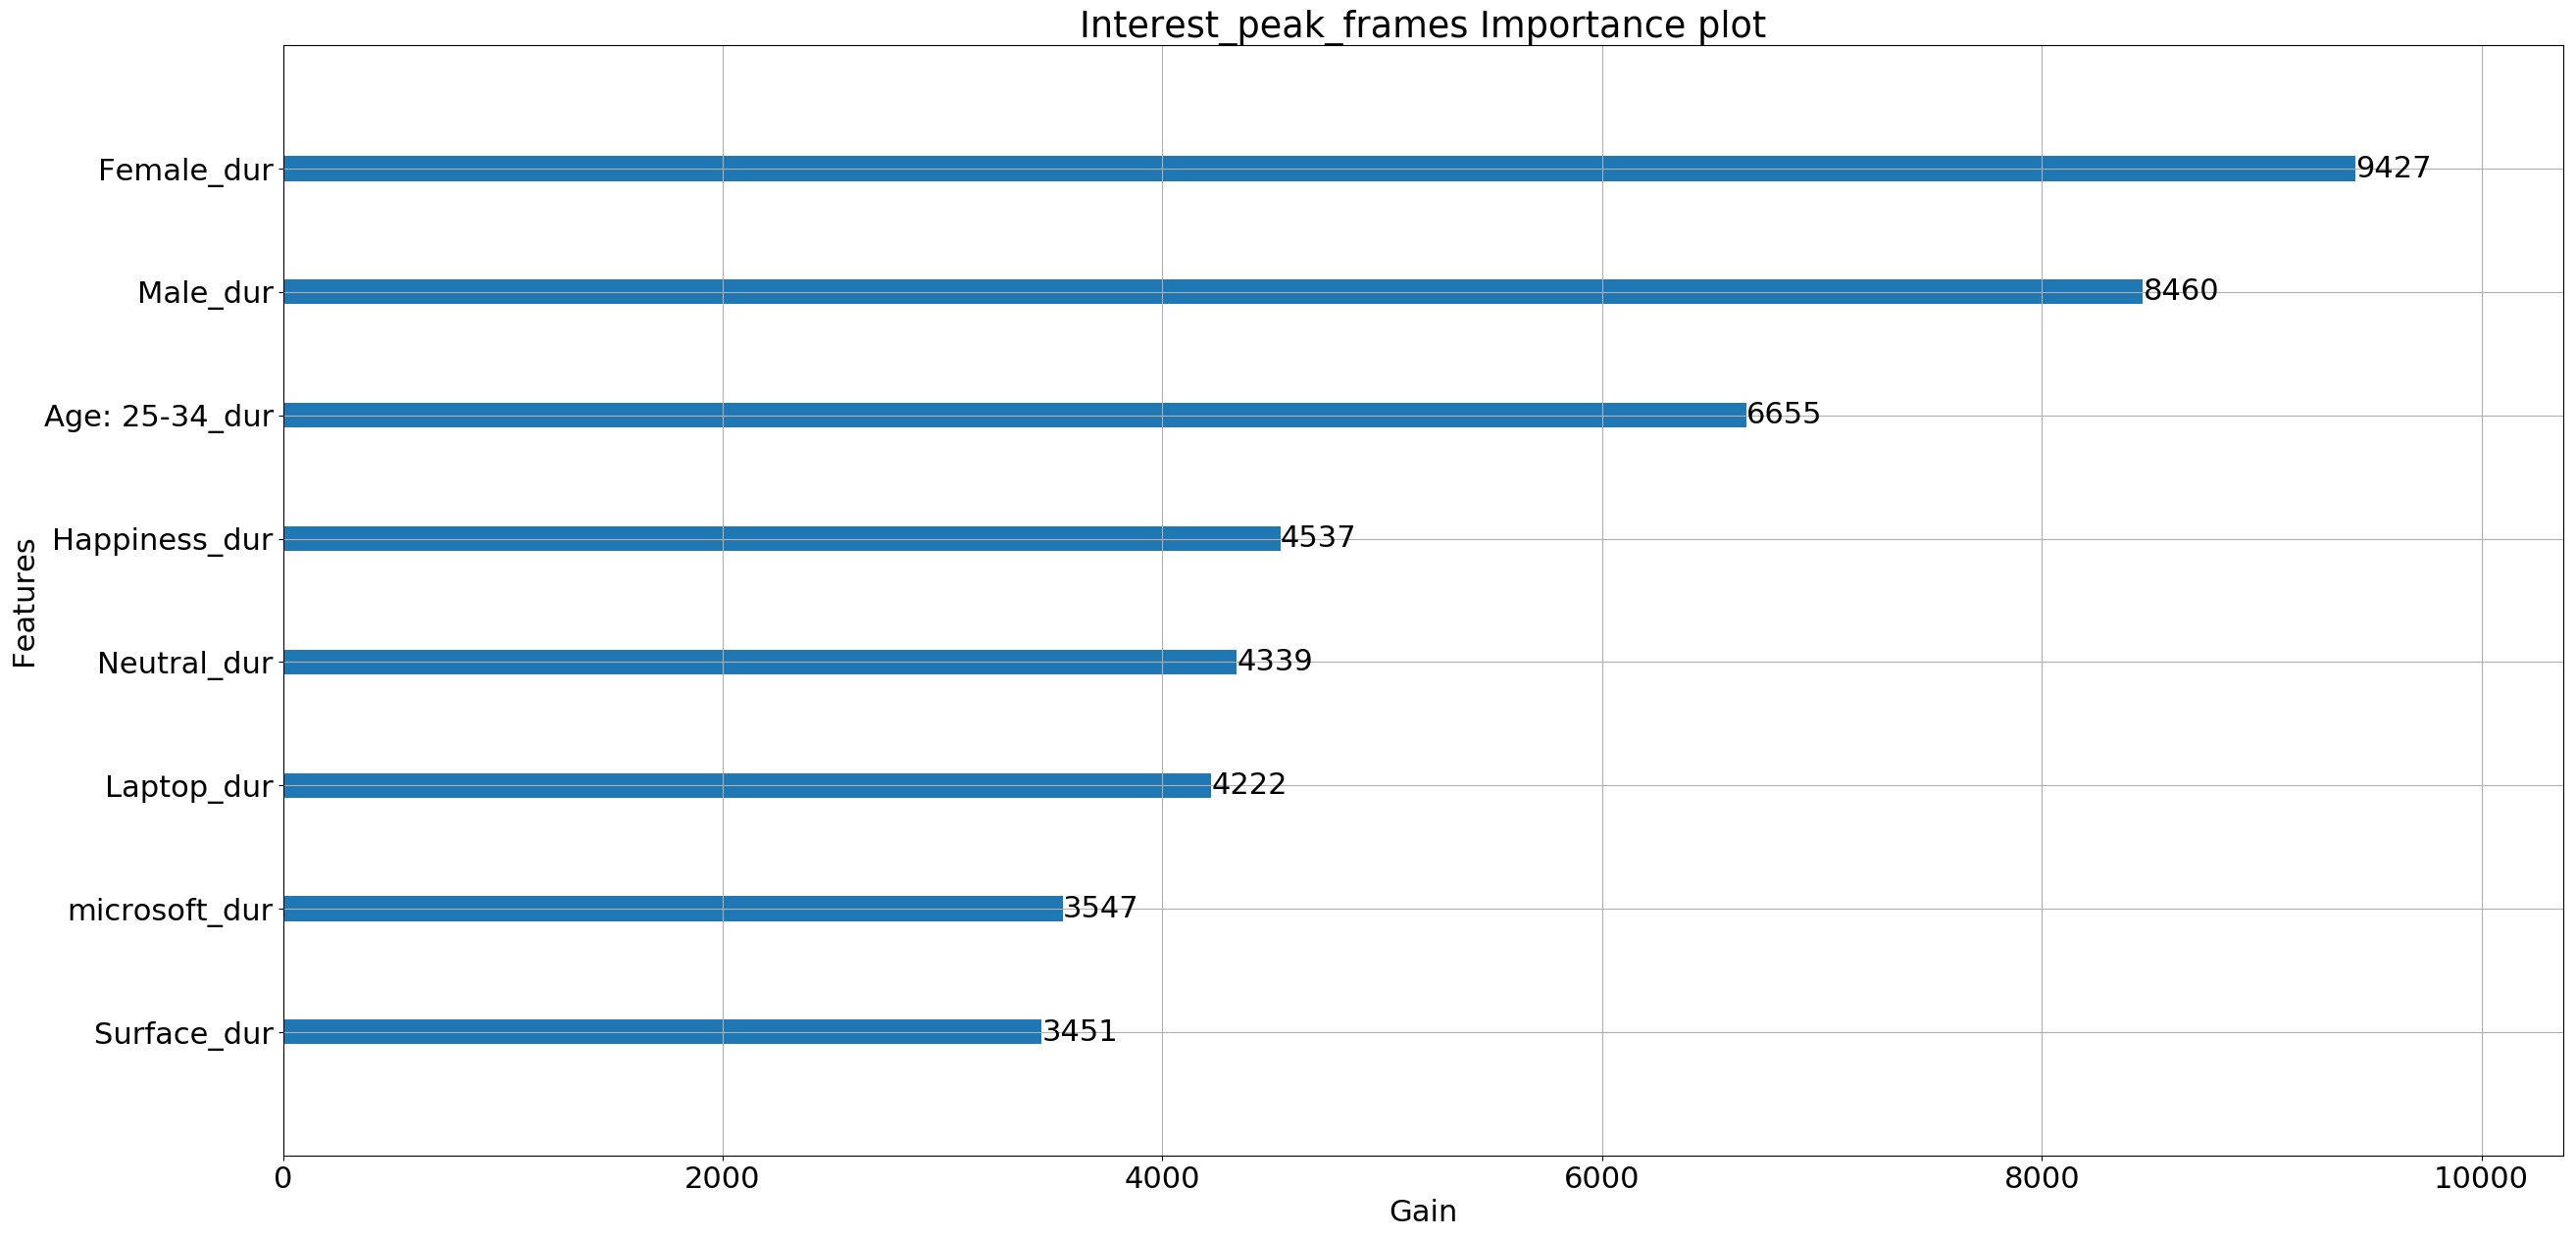

In [24]:
model.plot_feature_importance(models_4,10,y_train_4.columns,X_train_4.columns,savefig=False)

In [55]:
shap.initjs()
explainer=[]
shap_values=[]
for i in range(4):
    explainer.append(shap.TreeExplainer(models_4[i]))
    shap_values.append(explainer[-1].shap_values(X_train_4))
    print(i)

0
1
2
3


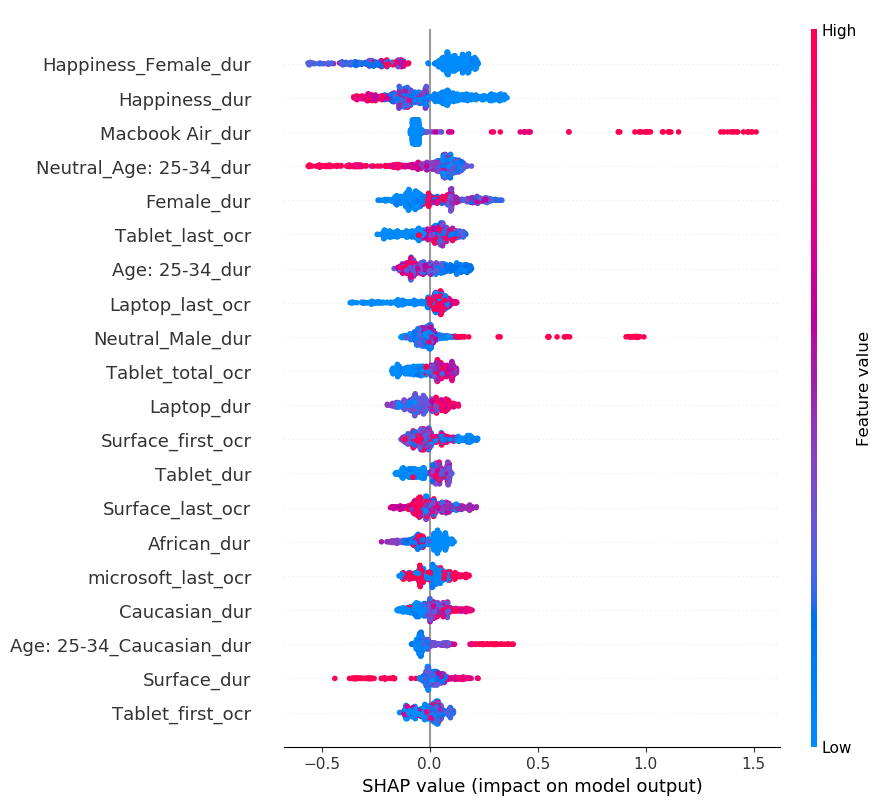

In [63]:
shap.summary_plot(shap_values[3],X_train_4)

In [60]:
X_train_14.to_excel('../../Version_1.01/x_train_14.xlsx')

In [61]:
X_test_14.to_excel('../../Version_1.01/x_test_14.xlsx')
y_train_14.to_excel('../../Version_1.01/y_train_14.xlsx')
y_test_14.to_excel('../../Version_1.01/y_test_14.xlsx')

In [62]:
X_train_4.to_excel('../../Version_1.01/x_train_4.xlsx')
X_test_4.to_excel('../../Version_1.01/x_test_4.xlsx')
y_train_4.to_excel('../../Version_1.01/y_train_4.xlsx')
y_test_4.to_excel('../../Version_1.01/y_test_4.xlsx')